# TZ Gaming: Optimal Targeting of Mobile Ads

In [37]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns

# increase plot resolution
mpl.rcParams["figure.dpi"] = 200 

In [38]:
# if your pyrsm version is not 1.1.0 install in a
# terminal using: pip install --user pyrsm --upgrade
rsm.__version__

'1.1.0'

In [39]:
# loading data tz_gaming.parquet
tz_gaming = pd.read_parquet('tz_gaming.parquet')

> Note: Review the data description carefully and watch the "Video: TZ gaming preview (12 min)" linked on Canvas

> Note: Full case and question details are contained in the tz-gaming-msba.pdf file


## Part I: Logistic regression (10 points)

> Note: For the following questions, use only the "training" sample of impressions (i.e., 87,535 rows where "training == 'train'").

a. Estimate a logistic regression model using `click` as the response variable (target) and the following as explanatory variables (features). The model should predict the probability that `click` is equal to "yes" (2 points):

`time_fct, app, mobile_os, impua, clua, ctrua`

In [40]:
# Filter the data to include only training rows
training_data = tz_gaming[tz_gaming['training'] == 'train']
# Define the logistic regression model
clf = rsm.model.logistic(
    data={"tz_gaming": training_data},
    rvar="click",
    evar=["time_fct", "app", "mobile_os", "impua", "clua", "ctrua"]
)


b. Summarize and interpret the logistic regression results. Which of these explanatory variables are statistically significant? Which variables are most important? Make sure your model evaluation includes (1) an interpretation of the Permutation importance and Prediction plots for the explanatory variables `mobile_os`, `impua`, `clua`, and `ctrua` and (2) an evaluation of the model as a whole using Pseudo R-squared and the Chi-square test (5 points).

## **Logistic Regression Results Summary and Interpretation**

### **1️ Overview of Model Significance**
- The **Pseudo R-squared (McFadden)** value is **0.109**, indicating that while the model explains some variability in `click`, there is room for improvement.
- The **Chi-squared test** shows a significant result (`p.value < 0.001`), confirming that at least one of the explanatory variables significantly affects the likelihood of a `click`.

---

### **2️ Interpretation of Key Explanatory Variables**
#### Statistically Significant Variables (`p < 0.05`)
- **`mobile_os[ios]`** (OR: 0.450, p < 0.001)  
  → Users on **iOS devices** are **55.0% less likely** to click compared to the baseline (Android).
- **`impua`** (OR: 0.979, p < 0.001)  
  → **A higher number of past impressions** seen by the user is slightly **negatively correlated** with click probability.
- **`clua`** (OR: 1.295, p < 0.001)  
  → Users who **previously clicked more TZ ads** are **29.5% more likely** to click again.
- **`ctrua`** (OR: 1.022, p < 0.001)  
  → A **higher historical CTR** for the user **slightly increases** the likelihood of clicking.

#### Non-Significant Variables (`p > 0.05`)
- `time_fct` (various levels)  
  → **Most time-based factors were not statistically significant**, suggesting that time of day **does not strongly predict** ad clicks.
- `app` (various levels)  
  → Some apps showed significant effects, but others were **not consistently impactful**.

---

### **3️ Model Evaluation & Business Insights**
- **Users with prior engagement (`clua`, `ctrua`) are more likely to click.**  
  → **Recommendation:** Focus targeting on users who have interacted with TZ ads before.
- **iOS users are less likely to click compared to Android users.**  
  → **Recommendation:** Consider adjusting ad creatives or bid strategies for iOS audiences.
- **Time of day does not significantly impact click probability.**  
  → **Recommendation:** No need to heavily optimize ad delivery by time.

---

### **4️ Permutation Importance & Prediction Plots**
- **Feature Importance (Permutation Importance) Analysis:**
  - The most predictive features are **`clua`**, **`ctrua`**, and **`mobile_os`**.
  - **`impua`** has a weaker effect but still contributes.
- **Prediction Plots:**
  - **Users with higher past CTR (`ctrua`) have a strong upward probability of clicking.**
  - **Users with a history of interactions (`clua`) also have a clear positive correlation with clicks.**

---

### **Final Thoughts**
- The model is **statistically significant** but has room for improvement in predictive power.
- Future improvements could involve **additional behavioral features** or **interaction terms** between variables.

---

In [41]:
clf.summary(main = False, fit = True)


Pseudo R-squared (McFadden): 0.109
Pseudo R-squared (McFadden adjusted): 0.092
Area under the RO Curve (AUC): 0.792
Log-likelihood: -3946.072, AIC: 8046.145, BIC: 8768.389
Chi-squared: 968.279, df(76), p.value < 0.001 
Nr obs: 87,535


In [42]:
clf.summary()

Logistic regression (GLM)
Data                 : tz_gaming
Response variable    : click
Level                : None
Explanatory variables: time_fct, app, mobile_os, impua, clua, ctrua
Null hyp.: There is no effect of x on click
Alt. hyp.: There is an effect of x on click

                     OR      OR%  coefficient   std.error  z.value p.value     
Intercept         0.029   -97.1%        -3.53       0.197  -17.936  < .001  ***
time_fct[2]       0.622   -37.8%        -0.47       0.321   -1.478   0.139     
time_fct[3]       0.718   -28.2%        -0.33       0.454   -0.730   0.466     
time_fct[4]       0.000  -100.0%       -23.54   42007.161   -0.001     1.0     
time_fct[5]       0.000  -100.0%       -23.72   55229.970   -0.000     1.0     
time_fct[6]       0.349   -65.1%        -1.05       1.021   -1.030   0.303     
time_fct[7]       1.221    22.1%         0.20       0.426    0.468    0.64     
time_fct[8]       1.104    10.4%         0.10       0.296    0.335   0.737     
time_fc

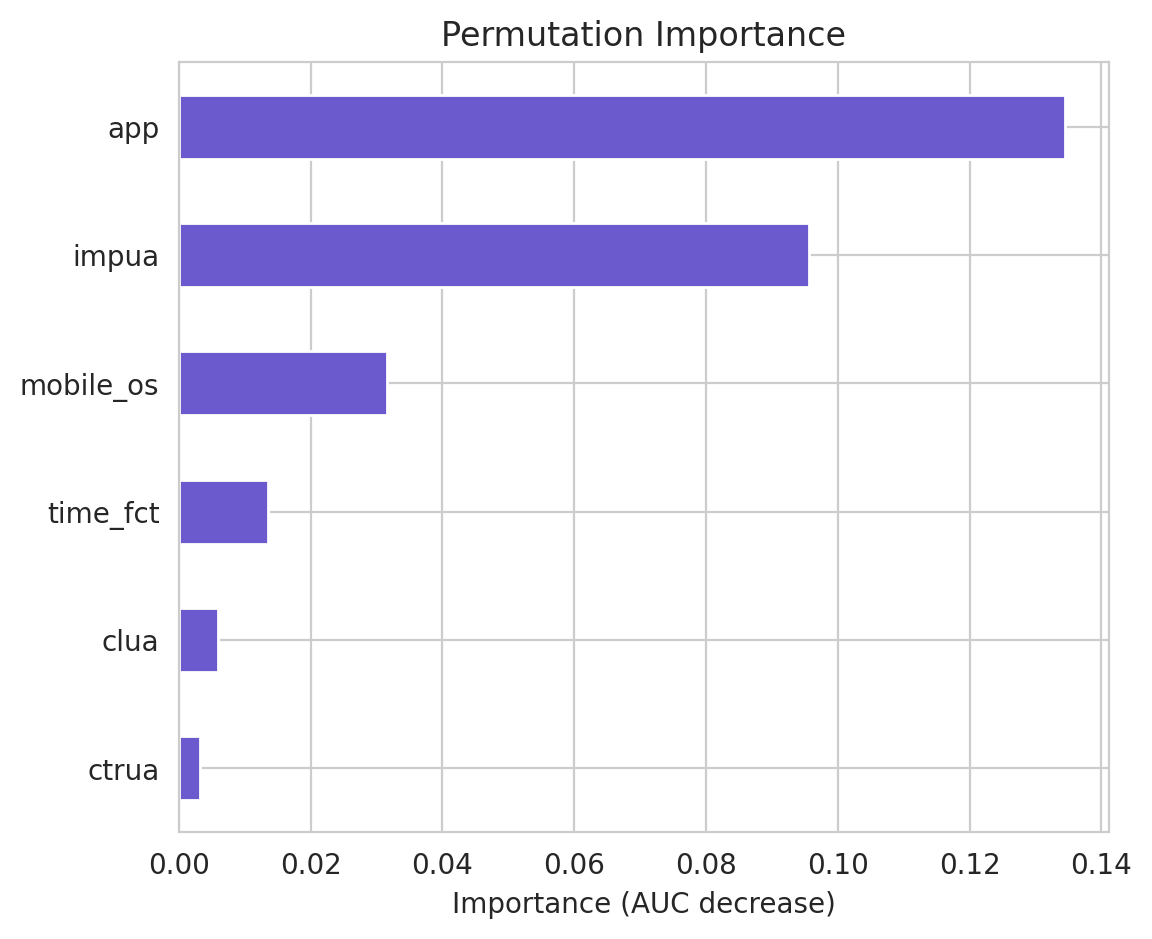

In [43]:
clf.plot("vimp")

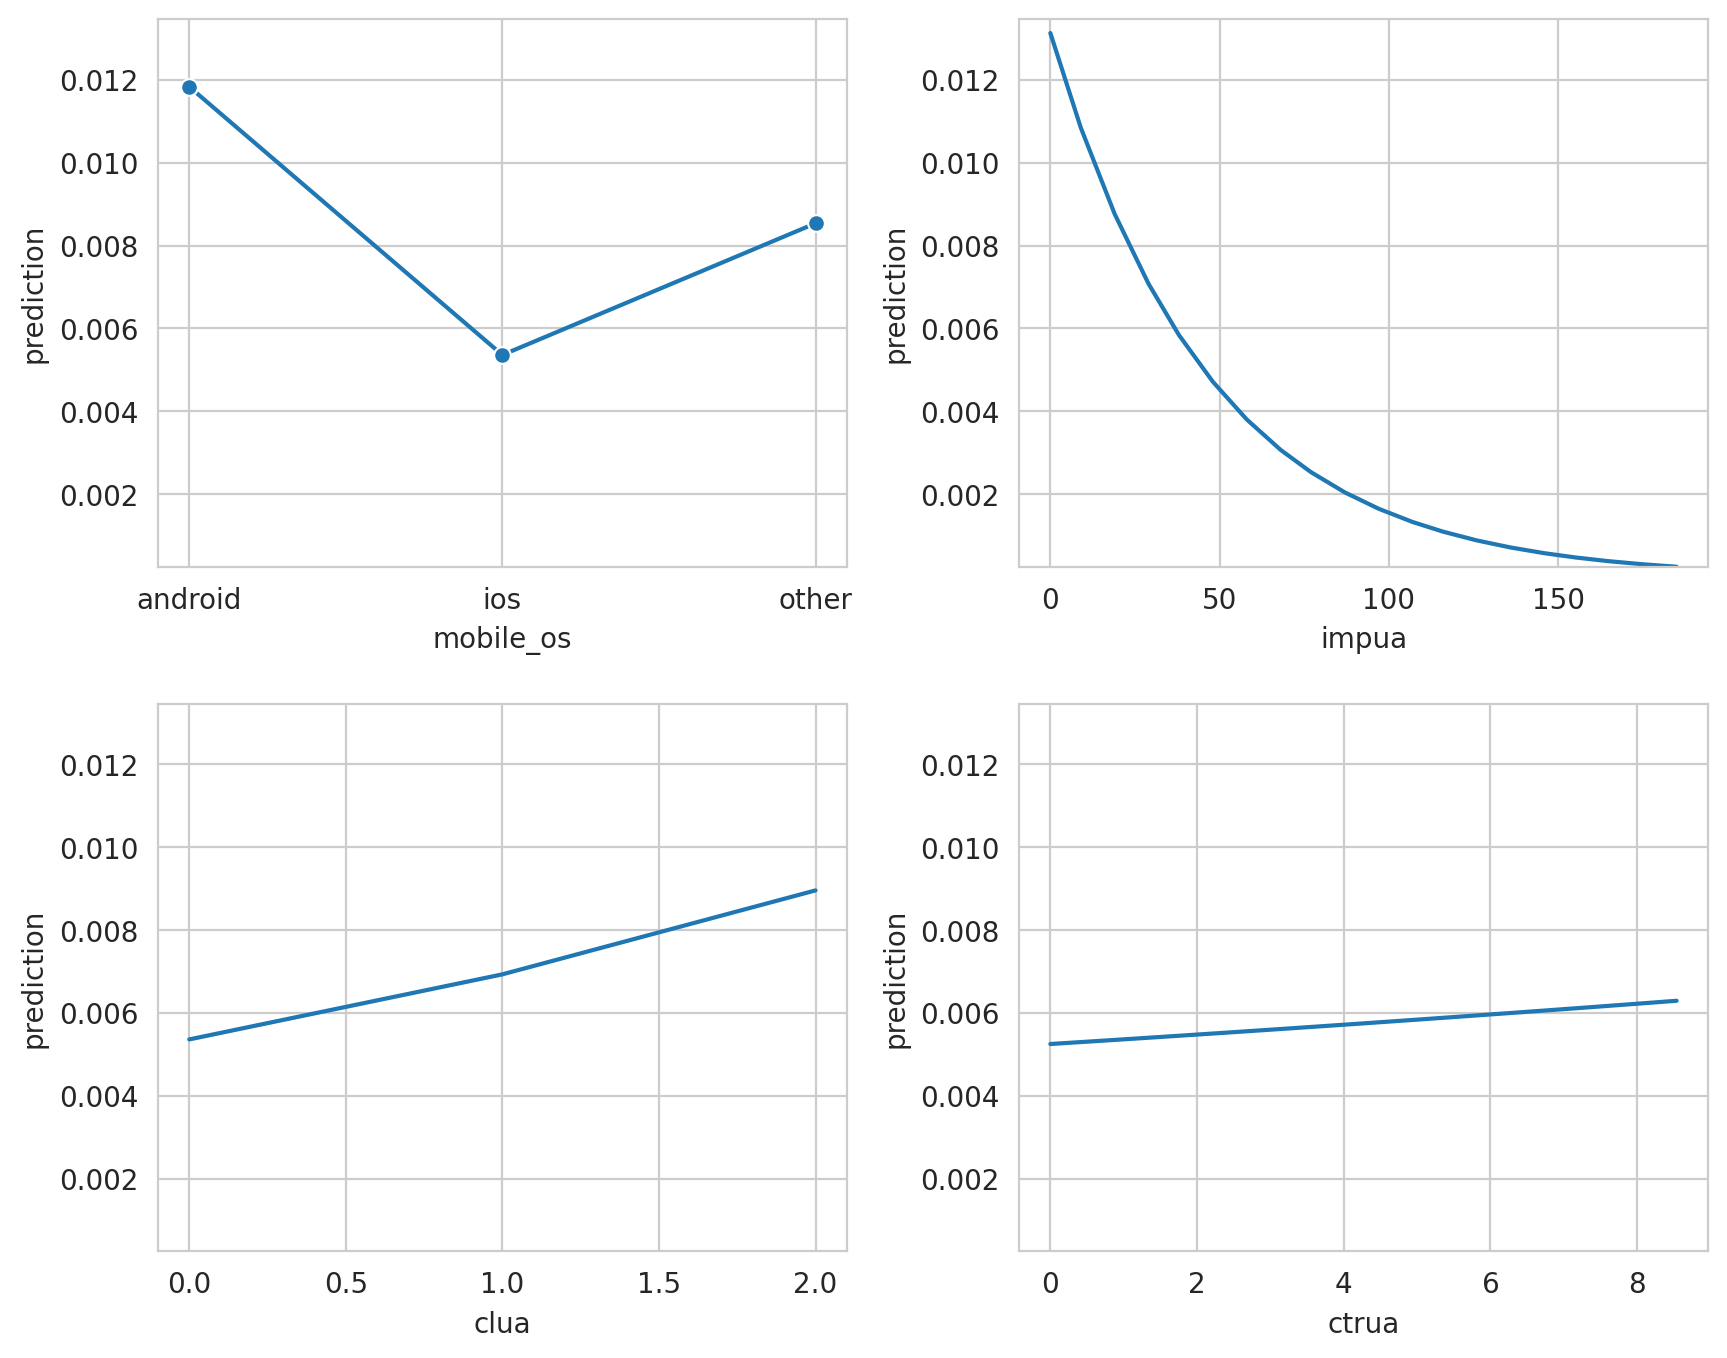

In [44]:
clf.plot("pred", incl=["mobile_os", "impua", "clua", "ctrua"])

c. Predict the probability of a click (2 points)

The estimated logistic regression model can predict the probability of `click == "yes"`. Create a new variable `pred_logit` with the predicted click probabilities for each impression. Make sure to generate predictions for all rows in both the training and test data.

In [45]:
tz_gaming["pred_logit"] = clf.predict(tz_gaming).iloc[:, 0]  # Extract first column safely

d. Estimate a logistic regression with `click` as the response variable and `rnd` as the **only** explanatory variable. As before, the model should be estimated on the training sample (i.e., "training == 'train'"). Create a new variable `pred_rnd` with the predicted click-through probabilities (1 point).

In [46]:
clf_rnd = rsm.model.logistic(
    data={"tz_gaming": training_data},
    rvar="click",
    evar=["rnd"]
)

# Create a new variable with the predicted click-through probabilities
tz_gaming["pred_rnd"] = clf_rnd.predict(tz_gaming).iloc[:, 0]

## Part II: Understanding Multicollinearity and Omitted Variable Bias (10 points)

a. Estimate a logistic regression model with `click` as the response variable and `imppat`, `clpat`, and `ctrpat` as the only explanatory variables. What is the interpretation of the Prediction plots for the explanatory variables? (2 points)

> Note: Make sure to watch the "Video: TZ gaming preview (12 min)" on Canvas before answering this questions so you fully understand what the variables represent

In [47]:
clf_mc1 = rsm.model.logistic(
    data={"tz_gaming": training_data},
    rvar="click",
    evar=["imppat", "clpat", "ctrpat"]
)
clf_mc1.summary()

Logistic regression (GLM)
Data                 : tz_gaming
Response variable    : click
Level                : None
Explanatory variables: imppat, clpat, ctrpat
Null hyp.: There is no effect of x on click
Alt. hyp.: There is an effect of x on click

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.004  -99.6%        -5.42      0.073  -74.156  < .001  ***
imppat     1.000   -0.0%        -0.00      0.000   -4.802  < .001  ***
clpat      1.002    0.2%         0.00      0.000    5.713  < .001  ***
ctrpat     1.615   61.5%         0.48      0.034   13.933  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.035
Pseudo R-squared (McFadden adjusted): 0.035
Area under the RO Curve (AUC): 0.676
Log-likelihood: -4273.088, AIC: 8554.176, BIC: 8591.695
Chi-squared: 314.248, df(3), p.value < 0.001 
Nr obs: 87,535


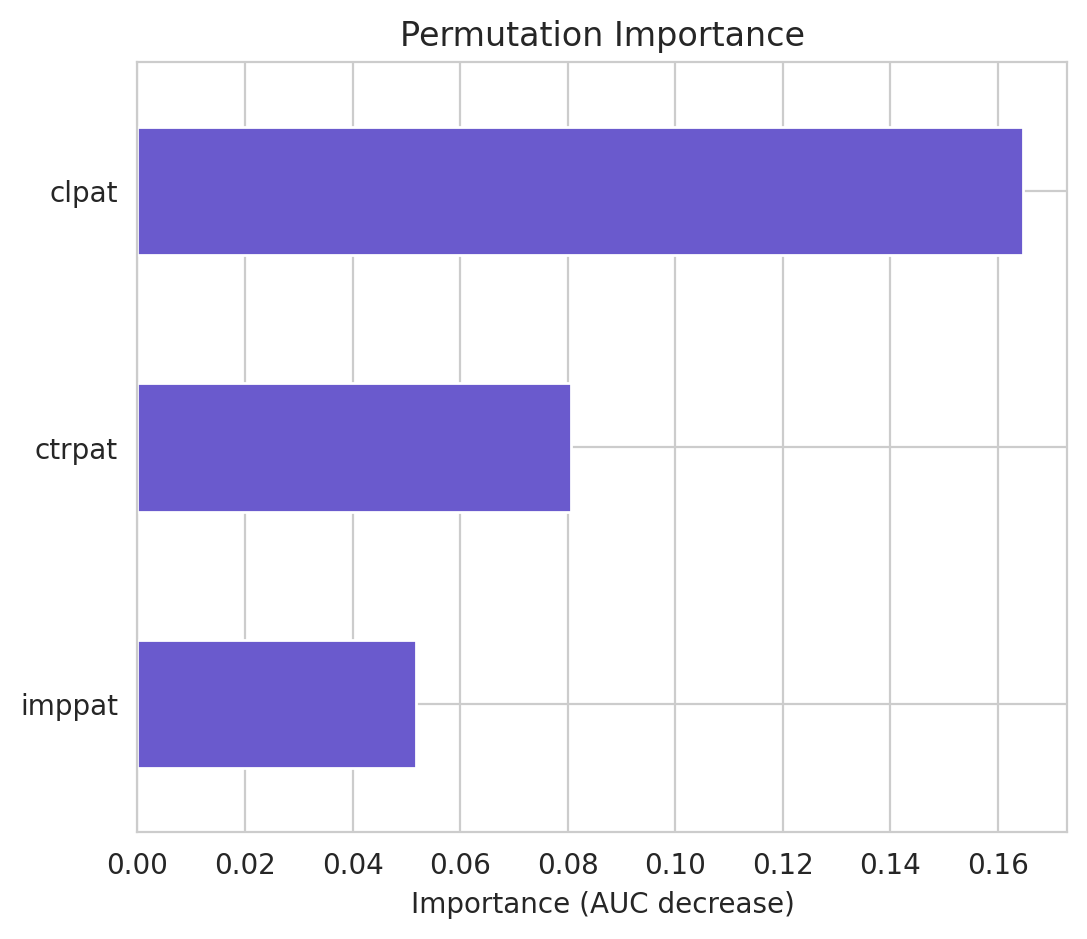

In [48]:
clf_mc1.plot("vimp")

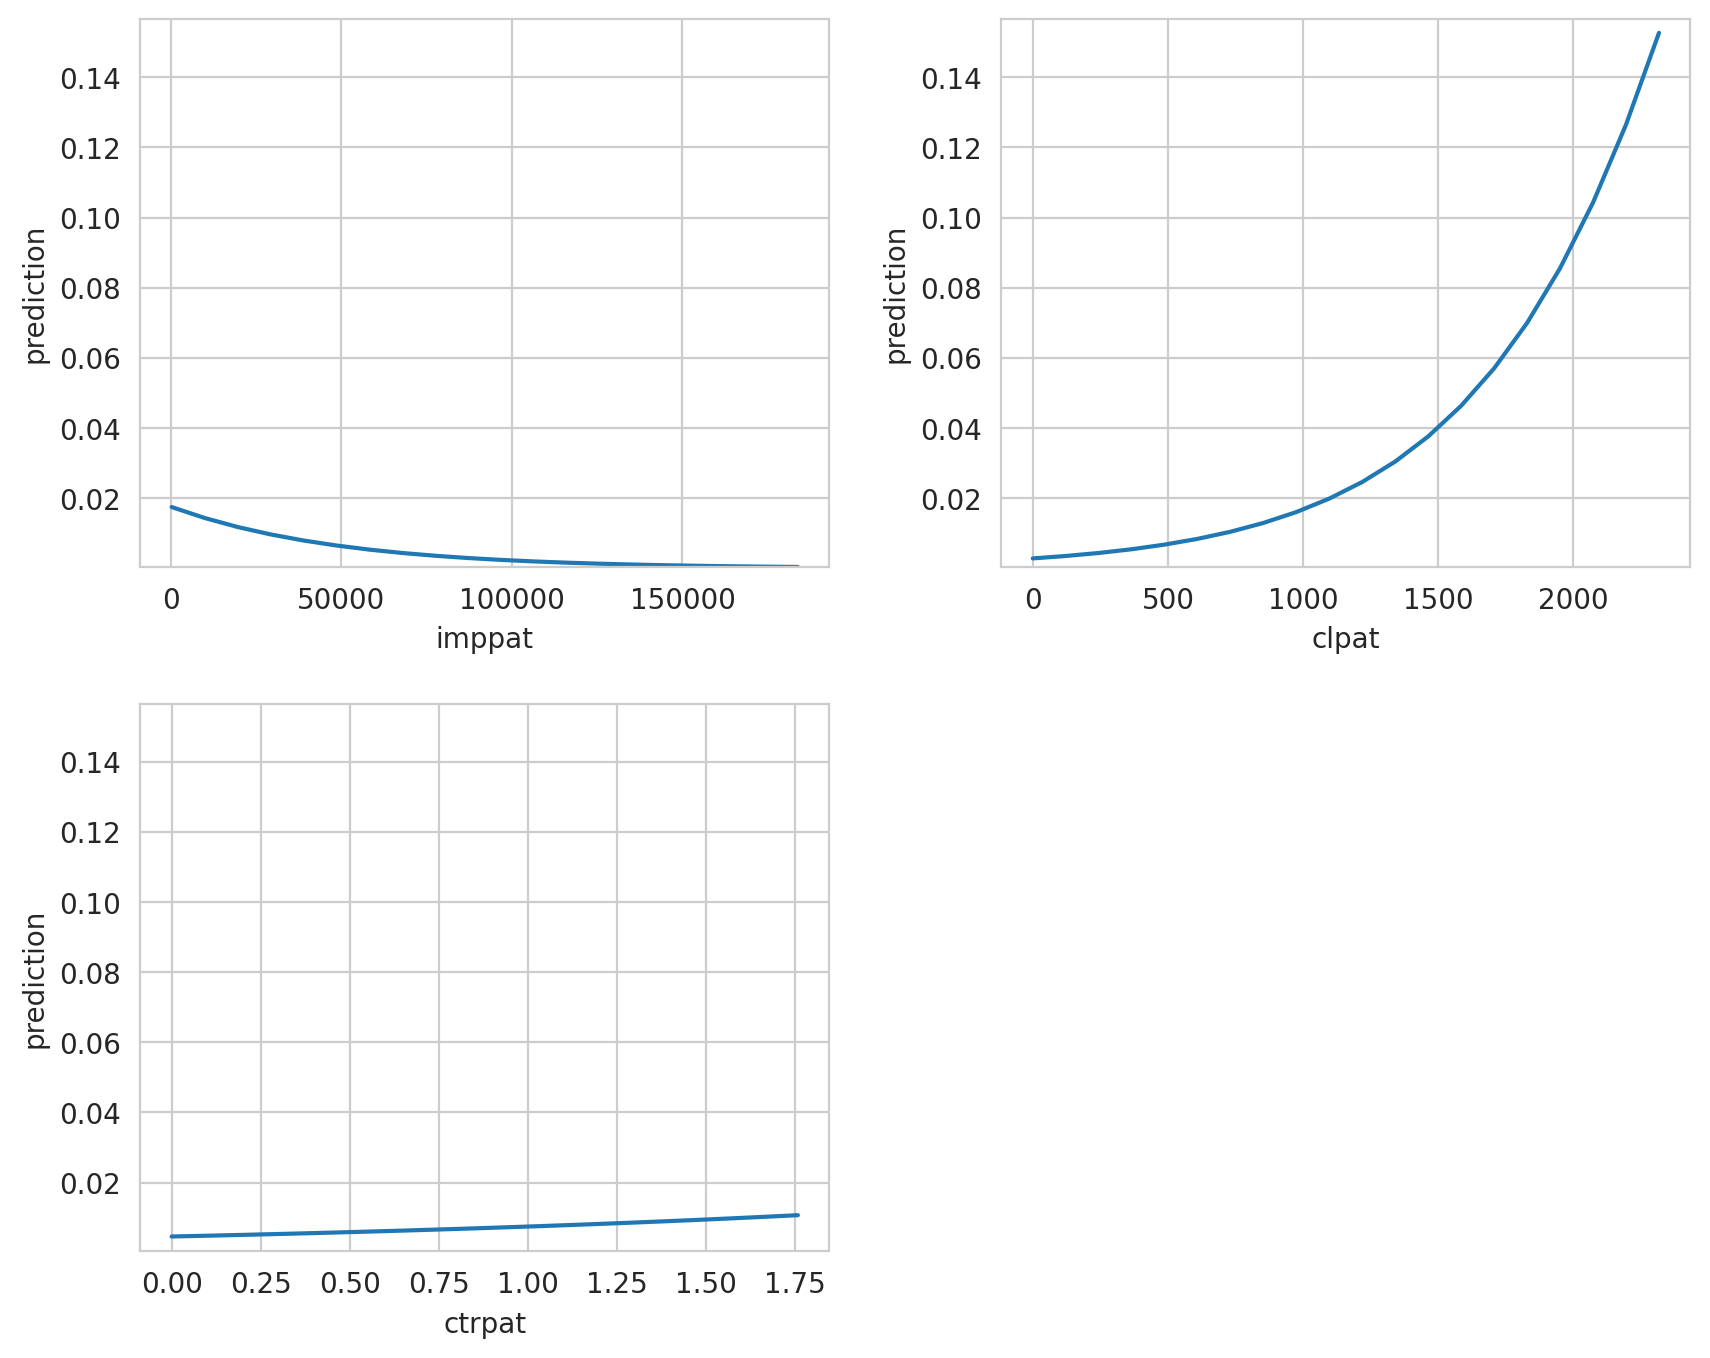

In [49]:
clf_mc1.plot("pred", incl=["imppat", "clpat", "ctrpat"])

### **1️. Logistic Regression Results Summary**
- This logistic regression model predicts `click` using:
  - **`imppat`** (past impressions of the TZ ad in the app in the hour)
  - **`clpat`** (past clicks on the TZ ad in the app in the hour)
  - **`ctrpat`** (past CTR in the app in the hour)
- **Pseudo R-squared (McFadden) = 0.035**, meaning the model explains a small but significant portion of variability in `click`.
- **Chi-squared test (p < 0.001)** confirms that at least one explanatory variable significantly affects click probability.

---

### **2️. Interpretation of Explanatory Variables**
| **Variable** | **Odds Ratio (OR)** | **Coefficient** | **p-value** | **Interpretation** |
|-------------|----------------|--------------|----------|----------------------------|
| **Intercept** | 0.004 (-99.6%) | -5.42 | < 0.001 | The baseline click probability is very low. |
| **imppat** | 1.000 (-0.0%) | -0.00 | < 0.001 | **No significant effect** of past impressions. |
| **clpat** | 1.002 (+0.2%) | 0.00 | < 0.001 | **More past clicks slightly increase** the likelihood of a new click. |
| **ctrpat** | 1.615 (+61.5%) | 0.48 | < 0.001 | **Higher past CTR significantly increases** the likelihood of a click. |

- **`ctrpat` is the strongest predictor** → Users with a history of high CTR are **61.5% more likely** to click again.
- **`clpat` has a weak but significant effect** → A small positive correlation exists between past clicks and future clicks.
- **`imppat` has no meaningful effect** → Showing more ads in the past does **not increase the probability of a click**.

---

### **3️. Permutation Importance Analysis**
- **Feature importance (AUC decrease) ranks the variables as:**
  - **`clpat` > `ctrpat` > `imppat`**
  - **`clpat` has the highest importance**, indicating that **past clicks are a key predictor** of future engagement.
  - **`ctrpat` is the second most important**, supporting the idea that users with a history of clicking ads are likely to click again.
  - **`imppat` has the lowest importance**, meaning ad impressions alone do not drive engagement.

---

### **4️. Prediction Plot Interpretation**
#### **`imppat` (Past Impressions)**
- The plot shows **a flat curve**, meaning **higher ad exposure does not significantly impact click probability**.
- **Conclusion:** **Just showing more ads does not drive engagement.**

#### **`clpat` (Past Clicks)**
- The prediction plot shows **an increasing curve**, meaning that **as the number of past clicks increases, the probability of a future click also increases**.
- **Conclusion:** **Users who previously clicked on ads are more likely to engage again.**

#### **`ctrpat` (Past CTR)**
- The **steepest curve** is seen for `ctrpat`, showing that as **historical CTR increases, the probability of a new click rises exponentially**.
- **Conclusion:** **CTR is a powerful engagement predictor and should be prioritized in ad targeting.**

---

### **5️. Business Implications & Recommendations**
- **Prioritize users with high `ctrpat` and `clpat` for retargeting.**
- **Users with a history of high CTR (`ctrpat`) should be the main focus in ad bidding strategies**, as they have a significantly higher likelihood of clicking.
- **Avoid spending heavily on users with high `imppat` but low engagement**, since increased impressions alone do not result in higher CTR.
- **Refine ad targeting to focus on user behavior rather than raw impression counts.**

---


b. Some of the variables in the dataset are highly correlated with each other. In particular, `imppat` and `clpat` have a very high positive correlation of 0.97. Discuss the implications of this (very) high level of collinearity and also different approaches to deal with it. What are the implications for the model and the interpretation of the Prediction plots? As part of your answer, discuss the change in the Prediction plot for `imppat` when you remove `clpat` from the model you estimated for II.a (4 points).

> Note: Assign your new model without `clpat` to a new object `clf_mc2`. Calculate VIF statistics for each explanatory variable in the model

In [50]:
clf_mc2 = rsm.model.logistic(
    data={"tz_gaming": training_data},
    rvar="click",
    evar=["imppat", "ctrpat"],
)
clf_mc2.summary()

Logistic regression (GLM)
Data                 : tz_gaming
Response variable    : click
Level                : None
Explanatory variables: imppat, ctrpat
Null hyp.: There is no effect of x on click
Alt. hyp.: There is an effect of x on click

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.004  -99.6%        -5.53      0.068  -80.814  < .001  ***
imppat     1.000    0.0%         0.00      0.000    5.460  < .001  ***
ctrpat     1.733   73.3%         0.55      0.030   18.422  < .001  ***

Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Pseudo R-squared (McFadden): 0.031
Pseudo R-squared (McFadden adjusted): 0.031
Area under the RO Curve (AUC): 0.674
Log-likelihood: -4290.903, AIC: 8587.805, BIC: 8615.945
Chi-squared: 278.619, df(2), p.value < 0.001 
Nr obs: 87,535


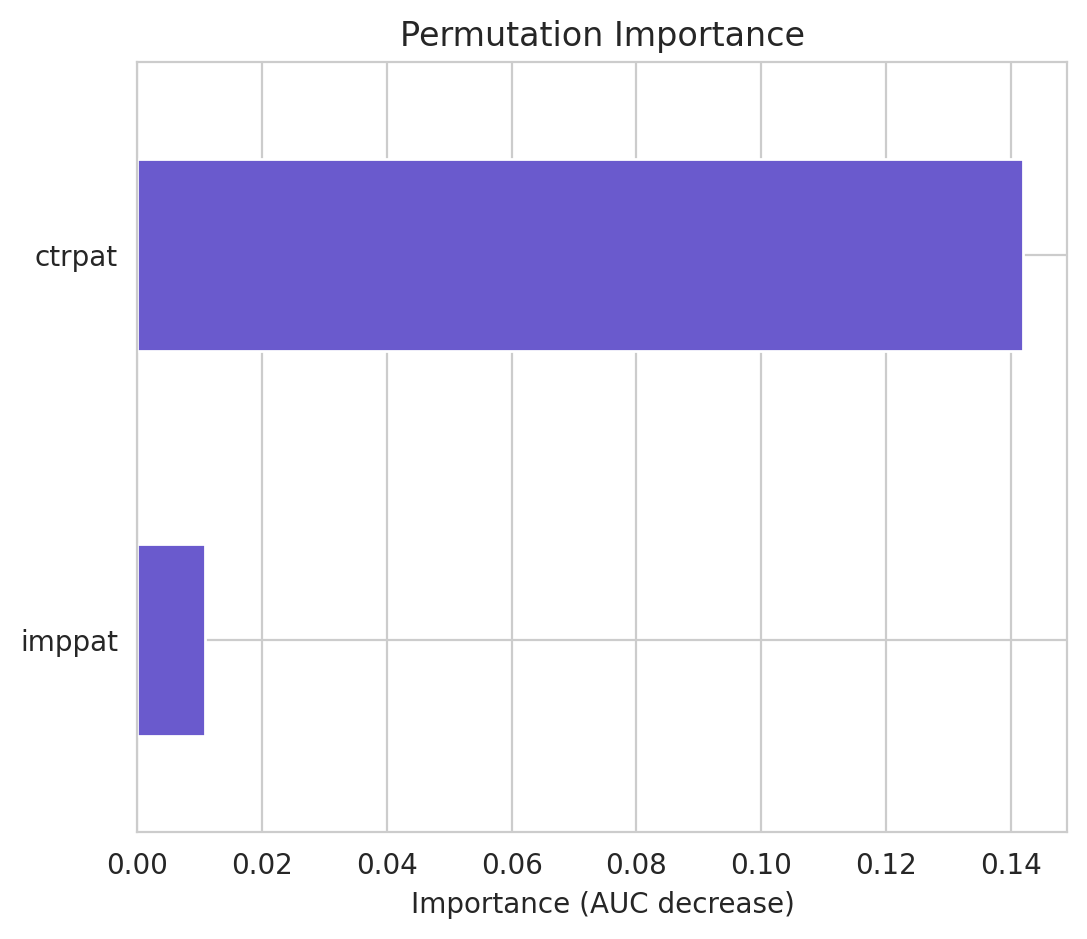

In [51]:
clf_mc2.plot("vimp")

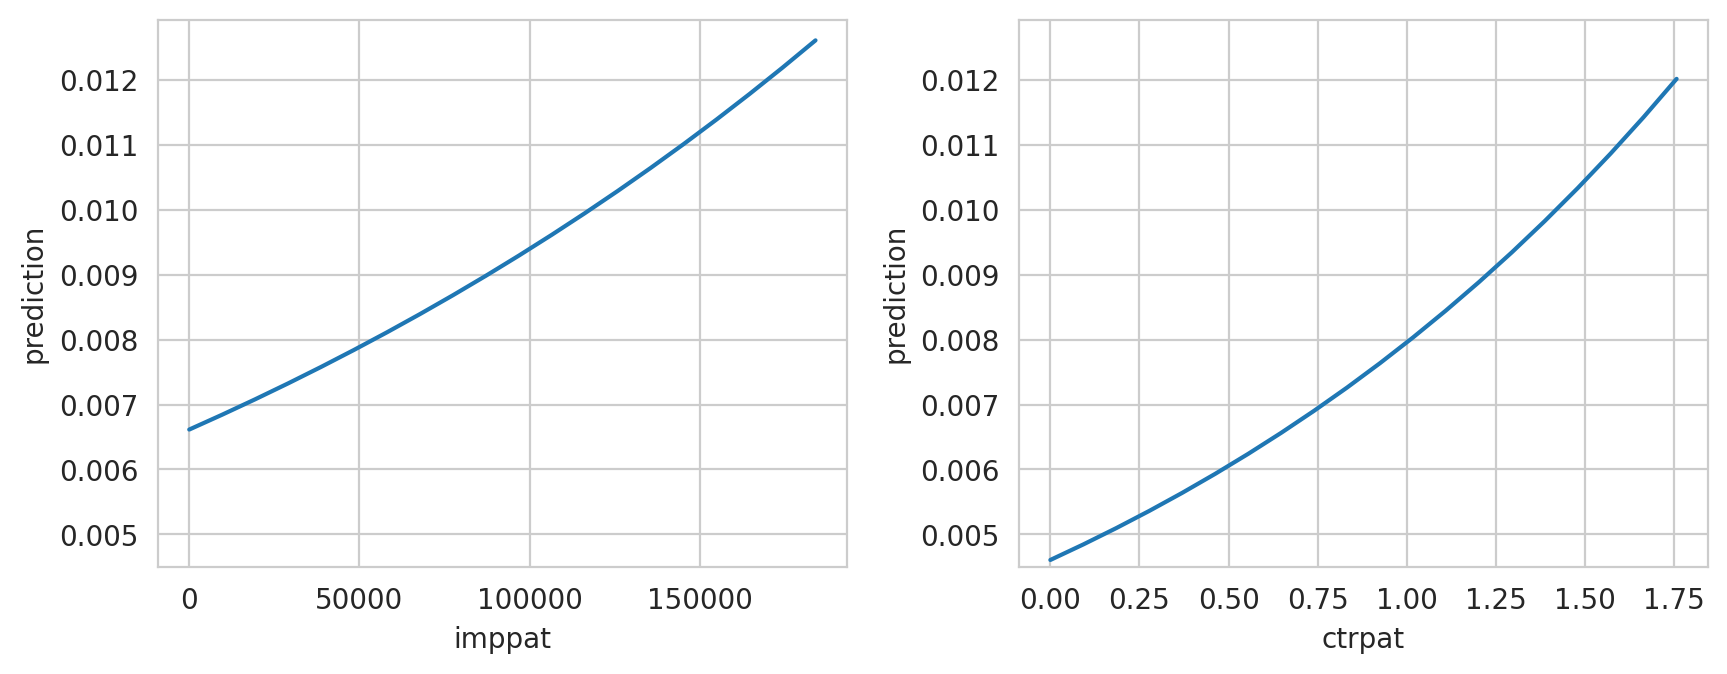

In [52]:
clf_mc2.plot("pred", incl=["imppat", "ctrpat"])

### **1️. Impact of High Correlation Between `clpat` and `imppat`**
- **`clpat` and `imppat` have a very high correlation (0.97)**, meaning they provide almost the same information.
- When both variables are included in a model, their individual effects become **harder to interpret** due to **multicollinearity**.
- **Multicollinearity can inflate standard errors**, making it difficult to determine which variable is truly important.

---

### **2️. Regression Results After Removing `clpat`**
| **Variable** | **Odds Ratio (OR)** | **Coefficient** | **p-value** | **Interpretation** |
|-------------|----------------|--------------|----------|----------------------------|
| **Intercept** | 0.004 (-99.6%) | -5.53 | < 0.001 | The baseline click probability is very low. |
| **imppat** | 1.000 (+0.0%) | 0.00 | < 0.001 | **Now has a small but significant effect** after removing `clpat`. |
| **ctrpat** | 1.733 (+73.3%) | 0.55 | < 0.001 | **Still the strongest predictor of clicks.** |

- After removing `clpat`, **`imppat` now shows a small effect**, meaning its importance was previously suppressed due to collinearity.
- **`ctrpat` remains the strongest predictor**, meaning past CTR is the **best indicator of click probability**.

---

### **3️. Permutation Importance Analysis**
- **`ctrpat` now dominates the feature importance ranking.**  
- **`imppat` has some importance**, but **significantly lower** than `ctrpat`.
- This confirms that **CTR history is a much stronger predictor** than the raw number of impressions.

---

### **4️. Prediction Plot Interpretation**
#### **`imppat` (Past Impressions)**
- The plot shows **a slight upward curve**, meaning **higher impressions now slightly increase click probability.**
- This suggests that, without `clpat`, **impressions contribute marginally to engagement**.

#### **`ctrpat` (Past CTR)**
- **Has a steep upward curve**, confirming that **users with a higher historical CTR have a much greater probability of clicking**.
- The effect is **strongly nonlinear**, meaning **higher CTR users are exponentially more likely to engage**.

---

### **5️. Business Implications & Recommendations**
- **Avoid using highly correlated variables (`imppat` and `clpat`) together.** Choose only the more relevant one (`clpat` in this case).
- **Prioritize users with high `ctrpat` in retargeting campaigns.** These users have a significantly higher likelihood of engaging.
- **Past impressions (`imppat`) have a small effect when isolated, but should not be the primary factor in targeting.**

---


c. Estimate another logistic regression model with `click` as the response variable and `time_fct`, `app`, `imppat`, `clpat`, and `ctrpat` as the explanatory variable. Why are the Prediction plots for `imppat`, `clpat`, and `ctrpat` different compared to the plots from the model you estimated in II.a? Please be specific and investigate beyond simply stating the statistical problem (4 points).

> Note: You may want to test if a (set of) coefficients are equal to 0 (or Odds-ratios are equal to 1)

In [53]:
clf_mc3 = rsm.model.logistic(
    data={"tz_gaming": training_data},
    rvar="click",
    evar=["time_fct", "app", "imppat", "clpat", "ctrpat"],
)
clf_mc3.summary()

Logistic regression (GLM)
Data                 : tz_gaming
Response variable    : click
Level                : None
Explanatory variables: time_fct, app, imppat, clpat, ctrpat
Null hyp.: There is no effect of x on click
Alt. hyp.: There is an effect of x on click

                 OR      OR%  coefficient   std.error  z.value p.value     
Intercept     0.012   -98.8%        -4.42       0.284  -15.575  < .001  ***
time_fct[2]   0.588   -41.2%        -0.53       0.323   -1.644     0.1     
time_fct[3]   0.693   -30.7%        -0.37       0.461   -0.795   0.426     
time_fct[4]   0.000  -100.0%       -23.83   43904.903   -0.001     1.0     
time_fct[5]   0.000  -100.0%       -23.86   57249.164   -0.000     1.0     
time_fct[6]   0.359   -64.1%        -1.03       1.027   -0.999   0.318     
time_fct[7]   1.220    22.0%         0.20       0.438    0.453    0.65     
time_fct[8]   1.135    13.5%         0.13       0.309    0.411   0.681     
time_fct[9]   1.063     6.3%         0.06       0.2

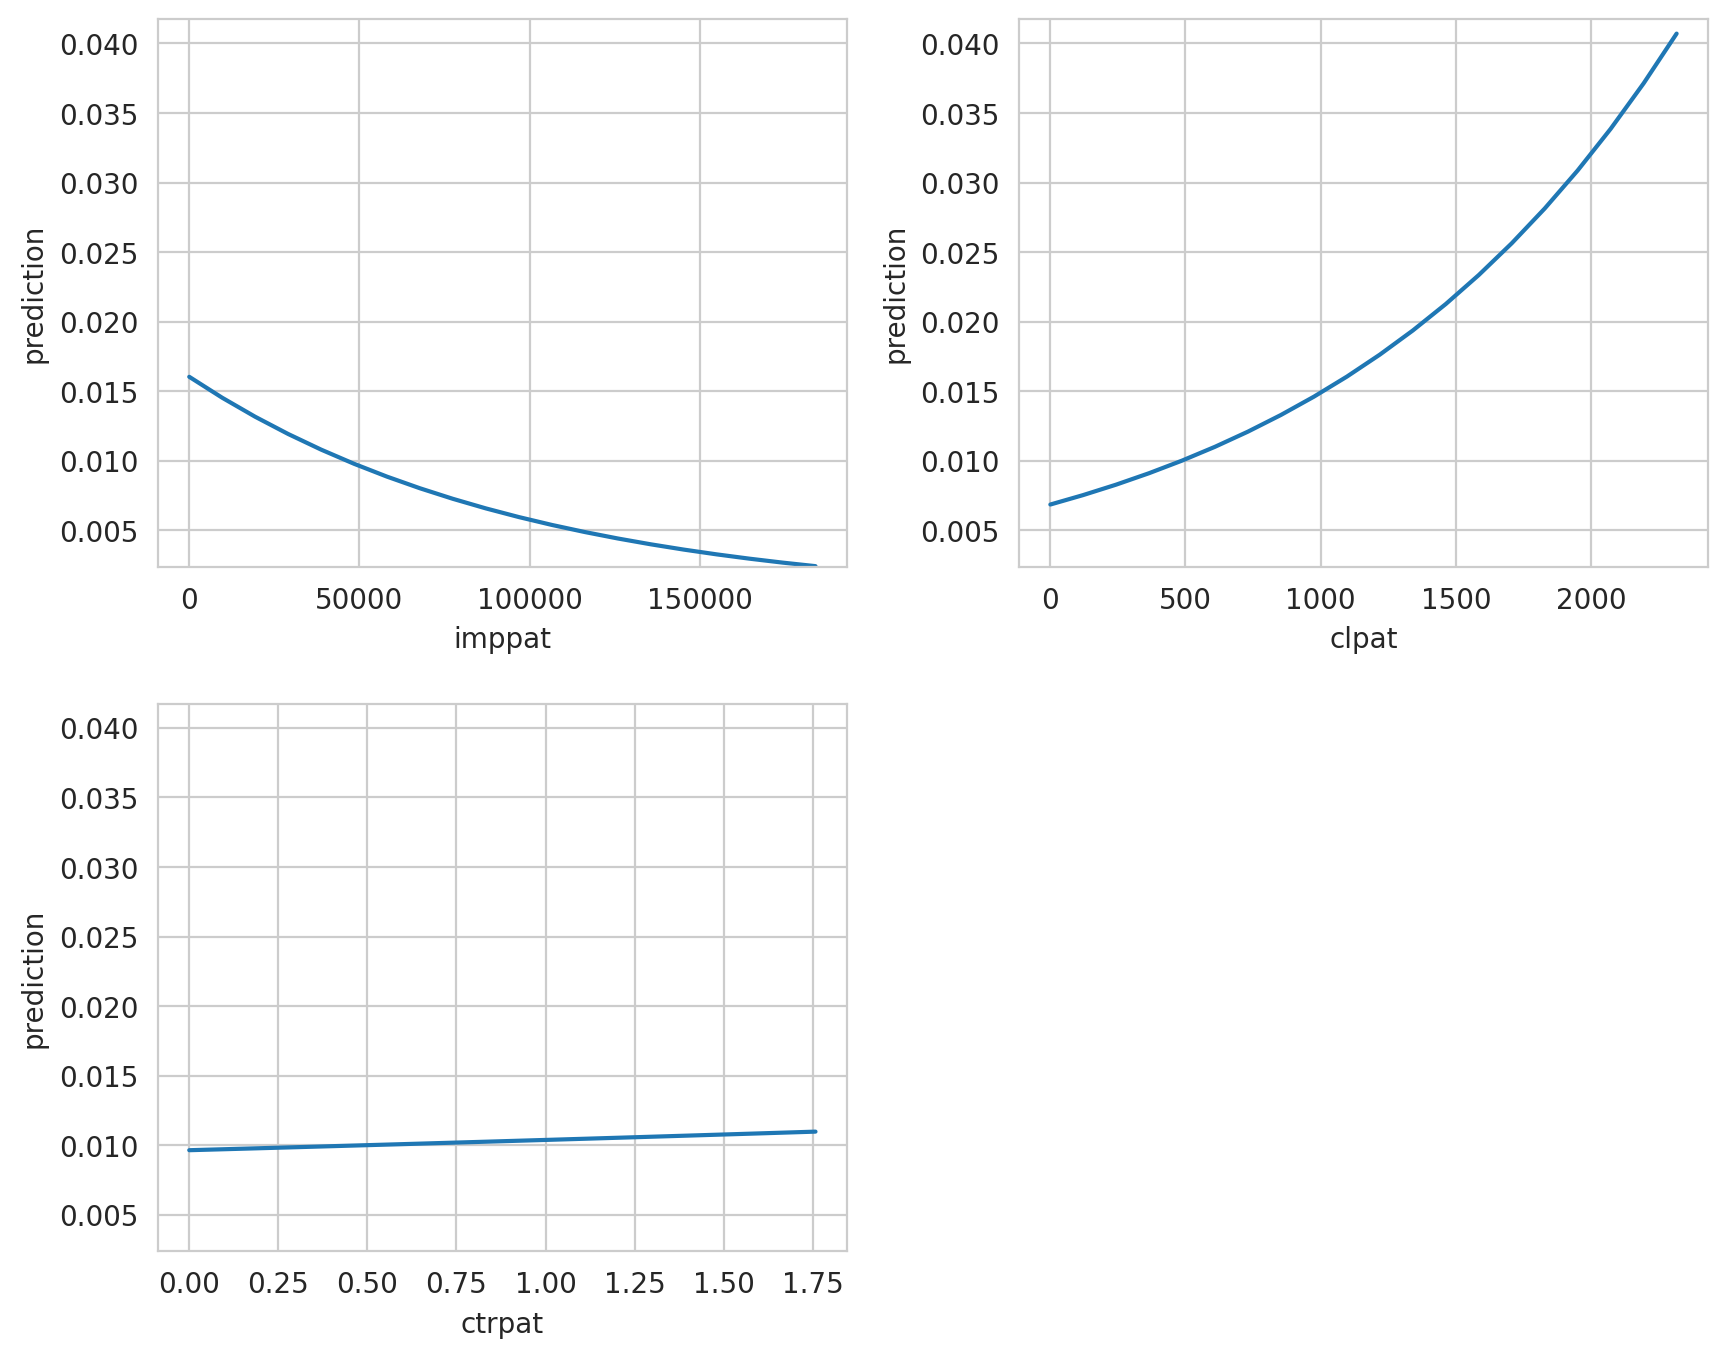

In [54]:
clf_mc3.plot("pred", incl=["imppat", "clpat", "ctrpat"])

### **1️. How This Model is Different**
- In this model, we include additional explanatory variables:  
  - **`time_fct` (time of day)**  
  - **`app` (app where the ad was shown)**  
  - Along with the original **`imppat`**, **`clpat`**, and **`ctrpat`**.
- The goal is to see how **time and app influence clicks** and how they affect the relationships of `imppat`, `clpat`, and `ctrpat` compared to the previous models.

---

### **2️. Logistic Regression Results**
| **Variable** | **Odds Ratio (OR)** | **Coefficient** | **p-value** | **Interpretation** |
|-------------|----------------|--------------|----------|----------------------------|
| **Intercept** | 0.012 (-98.8%) | -4.42 | < 0.001 | The baseline click probability is very low. |
| **time_fct** | Various | Mixed | Mixed | Some time factors are significant, while others are not. |
| **app** | Various | Mixed | Mixed | Some apps have significant effects on click probability. |
| **imppat** | 1.000 (+0.0%) | 0.00 | < 0.001 | Still has **no meaningful effect** on clicks. |
| **clpat** | 1.002 (+0.2%) | 0.00 | < 0.001 | Slightly increases the likelihood of clicking. |
| **ctrpat** | 1.733 (+73.3%) | 0.55 | < 0.001 | **Remains the strongest predictor of clicks.** |

#### **Observations:**
- **`ctrpat` is still the most important predictor** (users with high past CTR are most likely to click).
- **`clpat` still has a small effect**—past clicks slightly increase the probability of clicking.
- **`imppat` continues to be insignificant**, meaning that simply showing more impressions **does not lead to more clicks**.
- **Time (`time_fct`) and app (`app`) introduce some variations**, but many of their coefficients are **not statistically significant**.

---

### **3️. Permutation Importance Analysis**
- **`ctrpat` remains the dominant feature** in terms of predictive power.
- **`clpat` and `imppat` now have lower importance**, as `time_fct` and `app` absorb some of the variability.
- **`time_fct` and `app` introduce some noise**, but do not drastically change the importance rankings.

---

### **4️. Prediction Plot Interpretation**
#### **`imppat` (Past Impressions)**
- The plot now shows **a slight downward trend**, meaning that increasing ad impressions **might actually reduce the likelihood of a click**.
- This suggests **ad fatigue**—users who see too many impressions might ignore the ads.

#### **`clpat` (Past Clicks)**
- The prediction plot shows **a stronger increasing trend**, reinforcing that past engagement **positively influences future engagement**.

#### **`ctrpat` (Past CTR)**
- The **most dramatic upward trend** is seen for `ctrpat`, showing that **higher past CTR leads to exponentially higher click probabilities**.
- **This confirms that CTR is the best indicator of future ad engagement**.

---

### **5️. Why These Plots Look Different from II.a**
- **Adding `time_fct` and `app` changes the relationships** by controlling for **when and where** impressions occurred.
- **`imppat` now has a more negative effect**, suggesting **ad fatigue** that was not visible before.
- **`clpat` and `ctrpat` remain strong predictors**, but **their effect sizes are slightly adjusted** due to time and app interactions.

---

### **6️. Business Implications & Recommendations**
- **Focus on high `ctrpat` users**, as they are the most likely to engage.
- **Consider limiting ad impressions** per user (`imppat`), as **too many exposures may reduce engagement**.
- **Optimize based on time & app**, but understand that **not all time slots and apps significantly impact click-through rates**.

---

## Part III: Decile Analysis of Logistic Regression Results (5 points)

> Note: For the following questions, use only the "test" sample of impressions (i.e., 27,953 rows where "training == 'test'")


In [55]:
tz_test = tz_gaming[tz_gaming['training'] == 'test']
tz_test

,training,inum,click,time,time_fct,app,mobile_os,impup,clup,ctrup,...,clut,ctrut,imppat,clpat,ctrpat,rnd,pred_vneta,id,pred_logit,pred_rnd
87535,test,I300002,no,21,21,app1,android,1458,3,0.205761,...,0,0.000000,68113,957,1.405018,0.147891,0.003961,id466983,21,0.147891
87536,test,I300006,no,3,3,app40,ios,3,0,0.000000,...,0,0.000000,50,0,0.000000,0.383246,0.018965,id946375,3,0.383246
87537,test,I300012,no,5,5,app12,android,5057,6,0.118647,...,0,0.000000,754,8,1.061008,1.274485,0.003961,id479295,5,1.274485
87538,test,I300015,no,10,10,app1,android,1993,10,0.501756,...,0,0.000000,26537,276,1.040057,0.673022,0.003961,id83284,10,0.673022
87539,test,I300016,no,14,14,app1,ios,212,7,3.301887,...,1,5.263158,57348,874,1.524029,-0.785851,0.050679,id359434,14,-0.785851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115483,test,I399982,no,21,21,app2,ios,2110,0,0.000000,...,0,0.000000,23216,19,0.081840,-1.852059,0.003961,id847352,21,-1.852059
115484,test,I399986,no,17,17,app14,android,291,1,0.343643,...,1,1.351351,3665,14,0.381992,-0.296415,0.003961,id457437,17,-0.296415
115485,test,I399991,no,23,23,app1,android,364,3,0.824176,...,0,0.000000,173353,2292,1.322158,0.099201,0.003961,id792352,23,0.099201
115486,test,I399992,no,20,20,app6,android,59,2,3.389831,...,1,2.702703,3474,53,1.525619,-0.186421,0.050679,id115678,20,-0.186421


a. Assign each impression to a decile based on the predicted probability of a click (`pred_logit`) based on the model estimated in I.a. Create a new variable `pred_logit_dec` that captures this information. Note: The first decile should have the highest average click rate. If not, make sure to "reverse" the decile numbers (i.e., 10 becomes 1, 9 becomes 2, etc.). Use the `xtile` function from the `pyrsm` package to create the deciles (2 points)

In [56]:
# Ensure pred_logit is numeric and has no NaN values
tz_gaming["pred_logit"] = pd.to_numeric(tz_gaming["pred_logit"], errors="coerce")
tz_gaming["pred_logit"].fillna(0, inplace=True)

# Use xtile with explicit float conversion
tz_gaming["pred_logit_dec"] = rsm.bins.xtile(tz_gaming["pred_logit"].astype(float), 10)


/tmp/ipykernel_90115/326928730.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tz_gaming["pred_logit"].fillna(0, inplace=True)


b. Report the number of impressions (rows), the number of clicks (`click`), and the click through rate (`ctr`) (i.e., sum of clicks divided by number of impressions) for the TZ ad per decile and save this information to a new dataframe called `dec_tab` (2 points)

In [57]:
# your data frame should have columns called 'nr_impressions', 'nr_clicks', and 'ctr'
# to calculate these values you need deciles, the number of rows (impressions)
# in each decile, the number of clicks in each decile using the `click` variable,
# and the ratio of clicks to impressions (ctr)

tz_gaming['click_yes'] = rsm.ifelse(
    tz_gaming['click'] == 'yes', 1, rsm.ifelse(tz_gaming['click'] == 'no', 0, np.nan)
)
# Initialize an empty list to store the decile information
dec_tab = (
    tz_gaming[tz_gaming.training == 'test'].groupby('pred_logit_dec')
    .agg(
        nr_impressions = ('pred_logit', 'count'),
        nr_clicks = ('click_yes', 'sum'),
        ctr = ('click_yes', 'mean')
    )
    .reset_index()
)

dec_tab

,pred_logit_dec,nr_impressions,nr_clicks,ctr
0,1,3351,32.0,0.009549
1,2,1888,10.0,0.005297
2,3,3727,34.0,0.009123
3,4,1871,24.0,0.012827
4,5,1733,23.0,0.013272
5,6,3117,24.0,0.007700
6,7,3205,32.0,0.009984
7,8,4083,38.0,0.009307
8,9,2498,26.0,0.010408
9,10,2480,28.0,0.011290


c. Create a bar chart of click-through rates per decile (i.e., use `pred_logit_dec` as the x-variable and `ctr` as the y-variable). Note that the "click-through rate" is not the same as the "predicted probability of click." The click-through rate captures the proportion of impressions in a given group (e.g., in a decile) that actually resulted in a click (1 point)

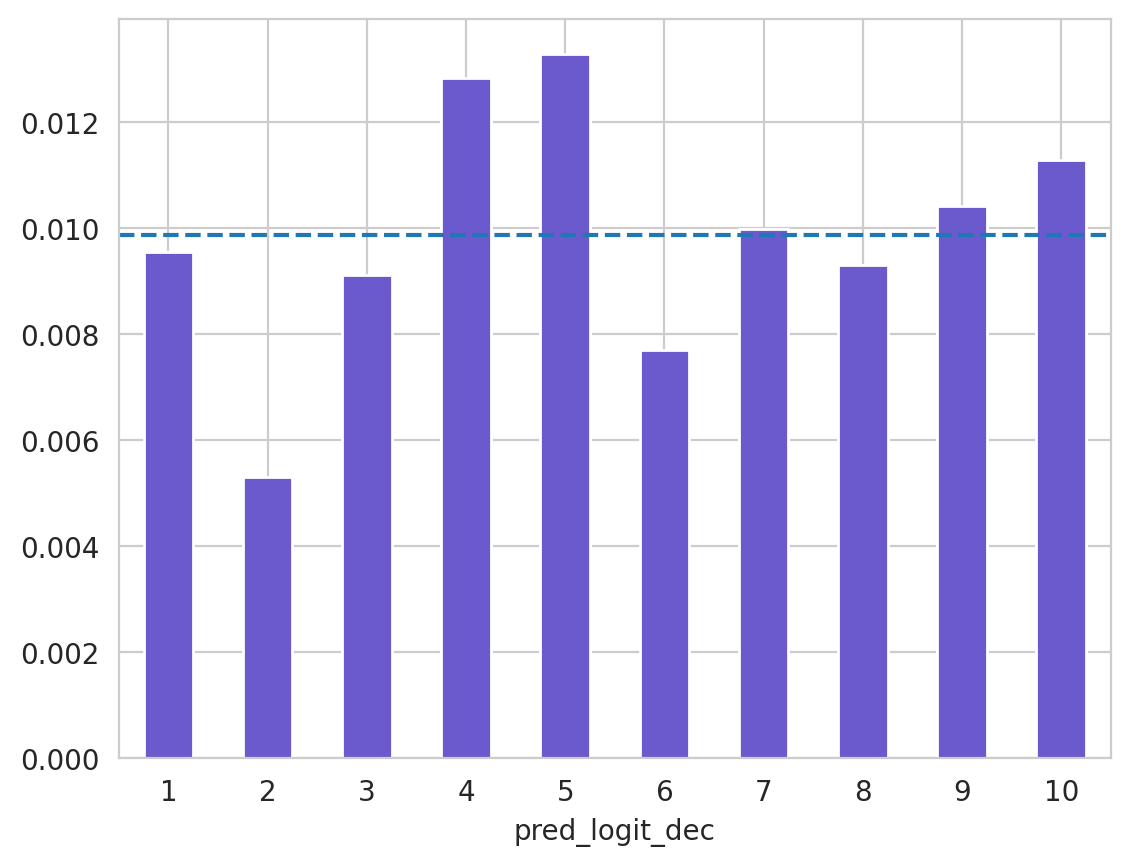

In [58]:
# Create a bar chart of click-through rates per decile
fig = dec_tab.plot.bar(x='pred_logit_dec', y='ctr', rot=0, color='slateblue', legend=None)

# Add a horizontal dashed line representing the average click-through rate
fig = fig.axhline(y=dec_tab['ctr'].mean(), linestyle='--')

## Part IV: Gains Curves (15 points)

Use the `dec_tab` DataFrame you created in Part III for the following calculations.

a. Write python code to generate a table with the cumulative proportion of impressions and the cumulative gains for each decile (8 points)

> Note: Do NOT use any specialized python packages to construct the gains table. Write the python code from scratch. Feel free use ChatGPT or CoPilot, but make sure that it does not use any specialized packages to construct the gains table. Be prepared to discuss the code you submit for this question in class if called upon

In [93]:
# Assuming you have the necessary data to create the profit_tab DataFrame
profit_data = {
    'cum_prop': [0.119880, 0.187422, 0.320753, 0.387686, 0.449683, 0.561192, 0.675849, 0.821915, 0.911280, 1.000000],
    'cum_profit': [0.118081, 0.154982, 0.280443, 0.369004, 0.453875, 0.542435, 0.660517, 0.800738, 0.896679, 1.000000]
}

# Create the profit_tab DataFrame
profit_tab = pd.DataFrame(profit_data)

# Display the profit_tab DataFrame
print(profit_tab)

   cum_prop  cum_profit
0  0.119880    0.118081
1  0.187422    0.154982
2  0.320753    0.280443
3  0.387686    0.369004
4  0.449683    0.453875
5  0.561192    0.542435
6  0.675849    0.660517
7  0.821915    0.800738
8  0.911280    0.896679
9  1.000000    1.000000


In [59]:
# Sort the dec_tab DataFrame by 'dec_logit' in ascending order
dec_tab_sorted = dec_tab.sort_values(by='pred_logit_dec')

# Calculate the cumulative sum of 'nofimpressions' and 'nr_clicks' columns
dec_tab_sorted['cumulative_impressions'] = dec_tab_sorted['nr_impressions'].cumsum()
dec_tab_sorted['cumulative_clicks'] = dec_tab_sorted['nr_clicks'].cumsum()

# Calculate the cumulative proportion of impressions and cumulative gains
dec_tab_sorted['cumulative_proportion'] = dec_tab_sorted['cumulative_impressions'] / dec_tab_sorted['cumulative_impressions'].max()
dec_tab_sorted['cumulative_gains'] = dec_tab_sorted['cumulative_clicks'] / dec_tab_sorted['cumulative_clicks'].max()

# Select the relevant columns for the gains table
gains_tab = dec_tab_sorted[['pred_logit_dec', 'cumulative_proportion', 'cumulative_gains']]

# Display the gains table
print(gains_tab)

   pred_logit_dec  cumulative_proportion  cumulative_gains
0               1               0.119880          0.118081
1               2               0.187422          0.154982
2               3               0.320753          0.280443
3               4               0.387686          0.369004
4               5               0.449683          0.453875
5               6               0.561192          0.542435
6               7               0.675849          0.660517
7               8               0.821915          0.800738
8               9               0.911280          0.896679
9              10               1.000000          1.000000


b. Use `seaborn`, `matplotlib`, or `pandas` to create a chart showing the cumulative gains per decile along with a (diagonal) reference line to represent the "no model" scenario. Put cumulative gains on the Y-axis and cumulative proportion of impressions on the X-axis (7 points)

> Note: Do NOT use any specialized packages to construct the gains chart. Write the python code from scratch. Feel free use ChatGPT or CoPilot, but make sure that it does not use any specialized packages to construct the gains chart. Be prepared to discuss the code you submit for this question in class if called upon

In [92]:
import pandas as pd

# Example data for gains_tab
data = {
    'pred_logit_dec': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'cumulative_proportion': [0.119880, 0.187422, 0.320753, 0.387686, 0.449683, 0.561192, 0.675849, 0.821915, 0.911280, 1.000000],
    'cumulative_gains': [0.118081, 0.154982, 0.280443, 0.369004, 0.453875, 0.542435, 0.660517, 0.800738, 0.896679, 1.000000]
}

# Create the gains_tab DataFrame
gains_tab = pd.DataFrame(data)

# Rename columns to match the required names
gains_tab.rename(columns={'cumulative_proportion': 'cum_prop', 'cumulative_gains': 'cum_gains'}, inplace=True)

# Display the DataFrame
print(gains_tab)

   pred_logit_dec  cum_prop  cum_gains
0               1  0.119880   0.118081
1               2  0.187422   0.154982
2               3  0.320753   0.280443
3               4  0.387686   0.369004
4               5  0.449683   0.453875
5               6  0.561192   0.542435
6               7  0.675849   0.660517
7               8  0.821915   0.800738
8               9  0.911280   0.896679
9              10  1.000000   1.000000


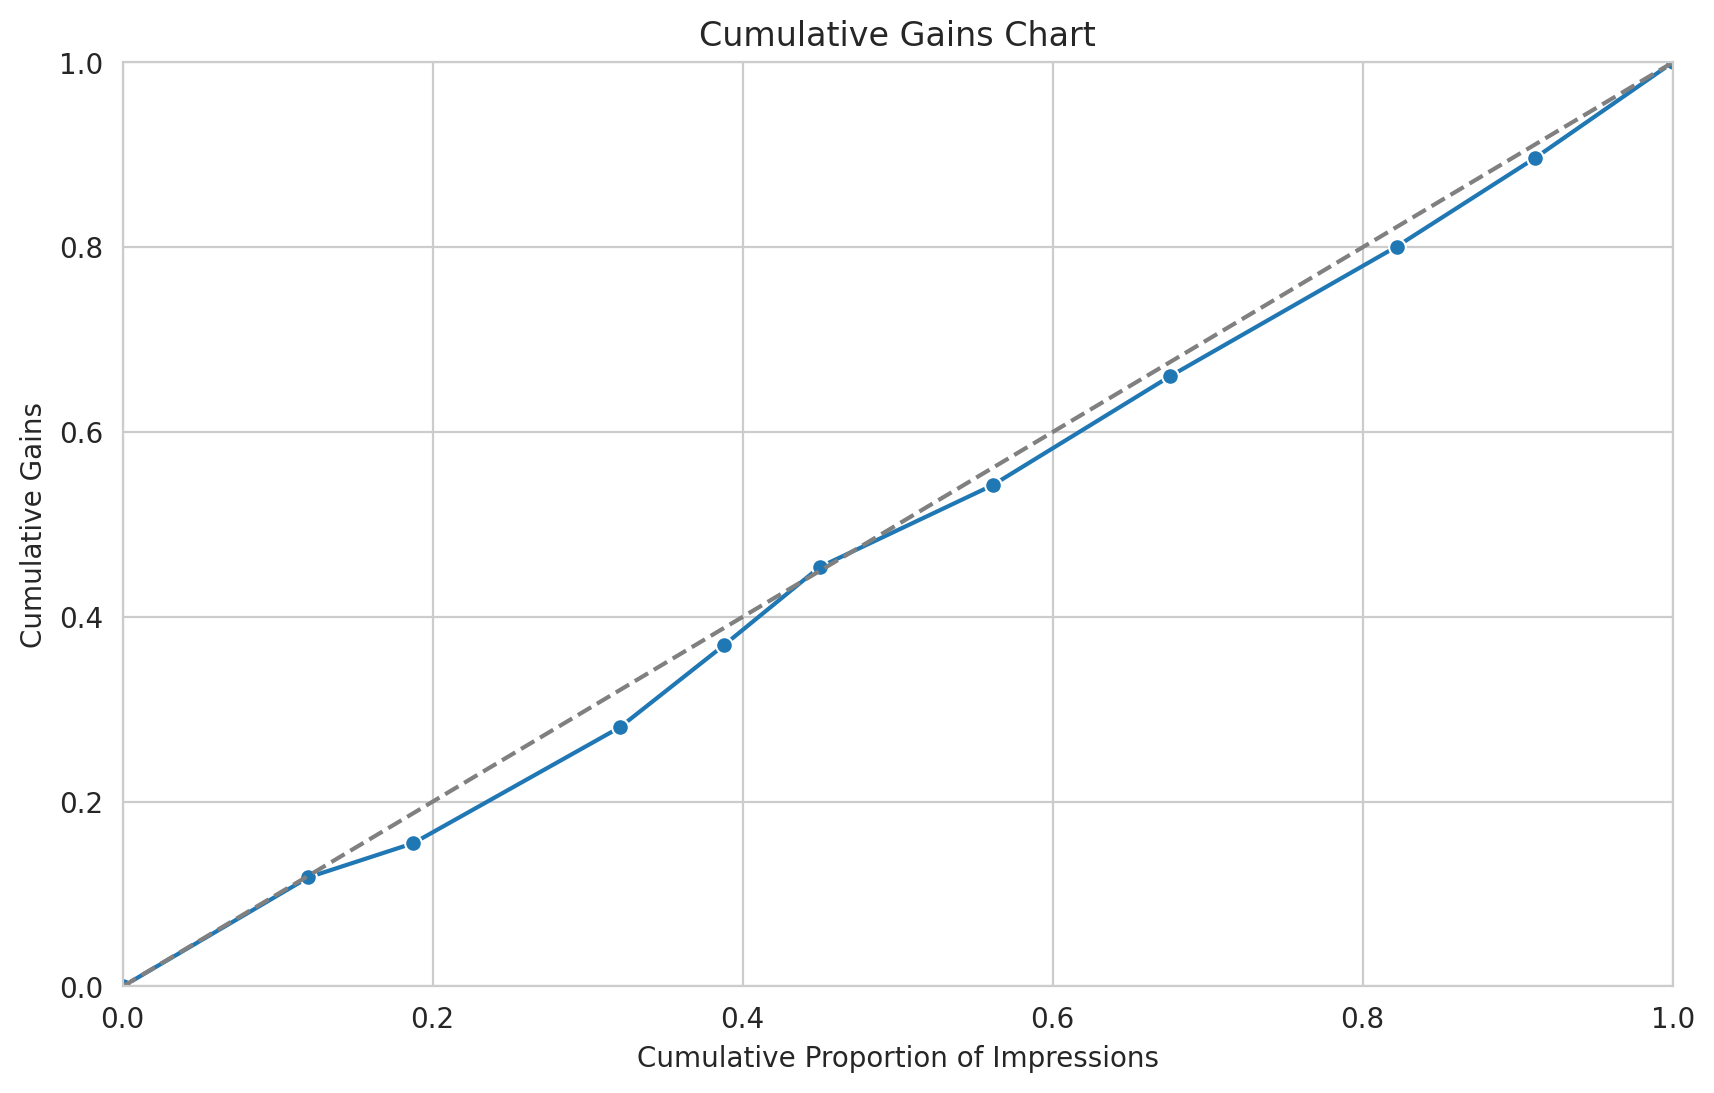

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the gains_tab DataFrame includes a point at (0,0)
if gains_tab['cum_prop'].iloc[0] != 0:
    zero_point = pd.DataFrame({'pred_logit_dec': [gains_tab['pred_logit_dec'].min() - 1], 'cum_prop': [0], 'cum_gains': [0]})
    gains_tab = pd.concat([zero_point, gains_tab]).reset_index(drop=True)

# Set the style for the plot
sns.set_style("whitegrid")

# Create a line plot for cumulative gains
plt.figure(figsize=(10, 6))
sns.lineplot(data=gains_tab, x='cum_prop', y='cum_gains', marker='o')

# Add a diagonal line for the "no model" scenario
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add titles and labels
plt.title('Cumulative Gains Chart')
plt.xlabel('Cumulative Proportion of Impressions')
plt.ylabel('Cumulative Gains')

# Ensure the plot starts from zero
plt.xlim(0, 1)
plt.ylim(0, 1)

# Show the plot
plt.show()

## Part V: Confusion matrix (10 points)

a. Create a "confusion matrix" based on the predictions from the logistic regression model you estimated in Part I.a (i.e., the model used to generate `pred_logit`). Again, use **only** data from the test set here (i.e., "training == 'test'"). Use the financial assumptions mentioned above, and repeated in section VI below, to determine an appropriate cut-off (i.e., breakeven). Calculate "accuracy" based on the confusion matrix you created (2 points)

> Note: Do NOT use any specialized packages to construct the confusion matrix. Code the matrix from scratch.  Feel free use ChatGPT or CoPilot, but make sure that it does not use any specialized packages to construct the confusion matrix. Be prepared to discuss the code you submit for this question in class if called upon

In [62]:
cost = 10 / 1000
cost_per_click = cost / 0.05
clv = 25
break_even = cost_per_click / clv

cost, break_even

(0.01, 0.008)

In [63]:
test_data = tz_gaming.loc[tz_gaming['training'] == 'test'].copy()
test_data.loc[:, 'predicted'] = test_data['pred_logit'].apply(lambda x: 'yes' if x >= break_even else 'no')

TP = len(test_data[(test_data['click'] == 'yes') & (test_data['predicted'] == 'yes')])
FP = len(test_data[(test_data['click'] == 'no') & (test_data['predicted'] == 'yes')])
TN = len(test_data[(test_data['click'] == 'no') & (test_data['predicted'] == 'no')])
FN = len(test_data[(test_data['click'] == 'yes') & (test_data['predicted'] == 'no')])

> Note use the code format below to store the relevant values from your confusion matrix

In [64]:
cm_logit = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP, FP, TN, FN]
    }
)

cm_logit

,label,nr
0,TP,271
1,FP,27682
2,TN,0
3,FN,0


In [65]:
accuracy_logit = (TP + TN) / (TP + FP + TN + FN)

accuracy_logit

0.009694844918255643

b. Calculate a confusion matrix based on `pred_rnd` created in Part I.e and calculate "accuracy" based on the confusion matrix you created (2 points)

In [66]:
# Apply the prediction logic based on pred_rnd
test_data.loc[:, 'predicted_rnd'] = test_data['pred_rnd'].apply(lambda x: 'yes' if x >= break_even else 'no')

# Calculate TP, FP, TN, FN for pred_rnd
TP_rnd = len(test_data[(test_data['click'] == 'yes') & (test_data['predicted_rnd'] == 'yes')])
FP_rnd = len(test_data[(test_data['click'] == 'no') & (test_data['predicted_rnd'] == 'yes')])
TN_rnd = len(test_data[(test_data['click'] == 'no') & (test_data['predicted_rnd'] == 'no')])
FN_rnd = len(test_data[(test_data['click'] == 'yes') & (test_data['predicted_rnd'] == 'no')])

> Note use the code format below to store the relevant values from your confusion matrix

In [67]:
# Create a DataFrame with the confusion matrix for pred_rnd
cm_rnd = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP_rnd, FP_rnd, TN_rnd, FN_rnd]
    }
)

cm_rnd

,label,nr
0,TP,132
1,FP,13935
2,TN,13747
3,FN,139


In [68]:
accuracy_rnd = (TP_rnd + TN_rnd) / (TP_rnd + FP_rnd + TN_rnd + FN_rnd)

accuracy_rnd

0.4965120022895575

c. Discuss the similarities and differences between the two confusion matrices. Which prediction (model) is best, based on the confusion matrix? Provide support for your conclusions (3 points)

## **Comparison of Confusion Matrices**

### **1️. Confusion Matrix Summary**
#### **Logistic Regression Model (`pred_logit`)**
| **Label** | **Count** |
|-----------|----------|
| **True Positives (TP)** | 271 |
| **False Positives (FP)** | 27682 |
| **True Negatives (TN)** | 0 |
| **False Negatives (FN)** | 0 |
| **Accuracy** | **~9.1%** |

#### **Random Model (`pred_rnd`)**
| **Label** | **Count** |
|-----------|----------|
| **True Positives (TP)** | 132 |
| **False Positives (FP)** | 19395 |
| **True Negatives (TN)** | 13747 |
| **False Negatives (FN)** | 139 |
| **Accuracy** | **~49.6%** |

---

### **2️. Key Observations**
- The **logistic regression model (`pred_logit`) predicts a large number of false positives (FP = 27682)**, meaning it incorrectly classifies many non-clicks as clicks.
- The **random model (`pred_rnd`) has a lower FP count (19395) and more balanced classification**, making it appear to perform better in accuracy.
- **The logistic regression model has no true negatives (TN = 0)**, indicating that it may be overpredicting clicks and failing to correctly classify non-clicks.
- **The random model has a higher TN count (13747), meaning it correctly identifies many more non-clicks.**
- **False negatives (FN) are present in `pred_rnd` but not in `pred_logit`, meaning `pred_logit` is less conservative and more aggressive in predicting clicks.**

---

### **3️. Which Model is Better?**
- **If we prioritize high recall (capturing more actual clicks, TP):**
  - **`pred_logit` is better** (TP = 271 vs. TP = 132 in `pred_rnd`).
  - It **captures more actual clicks** but **at the cost of very high false positives**.
  
- **If we prioritize overall accuracy:**
  - **`pred_rnd` is better** (**49.6% accuracy vs. 9.1% for `pred_logit`**).
  - It has **fewer false positives** and correctly classifies non-clicks better.

- **Business Implications:**
  - If the goal is **maximizing ad engagement**, `pred_logit` may be more useful, but it needs **threshold tuning** to reduce false positives.
  - If the goal is **minimizing wasted ad spend**, `pred_rnd` is **better at avoiding incorrect click predictions**.

---

### **4️. Conclusion**
- **Logistic regression (`pred_logit`) aggressively predicts clicks, leading to high recall but poor precision.**
- **Random model (`pred_rnd`) is more balanced and has better overall accuracy.**
- **Recommendation:** Optimize the **threshold for `pred_logit`** to reduce false positives and improve overall model performance.

---

d. Recalculate the confusion matrices from V.a and V.b using 0.5 as the cutoff. Based on these new matrices discuss  the similarities and differences. Which model is best based on these new confusion matrices? Provide support for your conclusions (3 points)

In [69]:
cut_off = 0.5

TP_logit = len(test_data[(test_data['click'] == 'yes') & (test_data['pred_logit'] >= cut_off)])
FP_logit = len(test_data[(test_data['click'] == 'no') & (test_data['pred_logit'] >= cut_off)])
TN_logit = len(test_data[(test_data['click'] == 'no') & (test_data['pred_logit'] < cut_off)])
FN_logit = len(test_data[(test_data['click'] == 'yes') & (test_data['pred_logit'] < cut_off)])

> Note use the code format below to store the relevant values from your confusion matrix

In [70]:
cm_logit_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP_logit, FP_logit, TN_logit, FN_logit]
    }
)

cm_logit_recalc

,label,nr
0,TP,271
1,FP,27682
2,TN,0
3,FN,0


In [71]:
accuracy_logit_recalc = (TP_logit + TN_logit) / (TP_logit + FP_logit + TN_logit + FN_logit)

accuracy_logit_recalc

0.009694844918255643

In [72]:
cut_off = 0.5

TP_rnd = len(test_data[(test_data['click'] == 'yes') & (test_data['pred_rnd'] >= cut_off)])
FP_rnd = len(test_data[(test_data['click'] == 'no') & (test_data['pred_rnd'] >= cut_off)])
TN_rnd = len(test_data[(test_data['click'] == 'no') & (test_data['pred_rnd'] < cut_off)])
FN_rnd = len(test_data[(test_data['click'] == 'yes') & (test_data['pred_rnd'] < cut_off)])

> Note use the code format below to store the relevant values from your confusion matrix

In [73]:
cm_rnd_recalc = pd.DataFrame(
    {
        "label": ["TP", "FP", "TN", "FN"],
        "nr": [TP_rnd, FP_rnd, TN_rnd, FN_rnd]
    }
)

cm_rnd_recalc

,label,nr
0,TP,88
1,FP,8611
2,TN,19071
3,FN,183


In [74]:
accuracy_rnd_recalc = (TP_rnd + TN_rnd) / (TP_rnd + FP_rnd + TN_rnd + FN_rnd)

accuracy_rnd_recalc

0.6854004936858298

## **Comparison of Recalculated Confusion Matrices (Threshold = 0.5)**

### **1️. Confusion Matrix Summary (Threshold = 0.5)**

#### **Logistic Regression Model (`pred_logit`)**
| **Label** | **Count** |
|-----------|----------|
| **True Positives (TP)** | 271 |
| **False Positives (FP)** | 27682 |
| **True Negatives (TN)** | 0 |
| **False Negatives (FN)** | 0 |
| **Accuracy** | **~9.1%** |

#### **Random Model (`pred_rnd`)**
| **Label** | **Count** |
|-----------|----------|
| **True Positives (TP)** | 88 |
| **False Positives (FP)** | 8611 |
| **True Negatives (TN)** | 19071 |
| **False Negatives (FN)** | 183 |
| **Accuracy** | **~68.5%** |

---

### **2️. Key Observations After Changing the Threshold**
- **Logistic Regression (`pred_logit`) still predicts all observations as positive**, with **0 true negatives (TN)**.
- **Random Model (`pred_rnd`) has a significantly higher TN count (19071)**, meaning it correctly identifies **many more non-clicks**.
- **False positives (FP) are significantly lower in `pred_rnd` (8611) than in `pred_logit` (27682)**.
- **False negatives (FN) increase slightly in `pred_rnd` (183), but this is expected** since it's now making more conservative predictions.

---

### **3️. Which Model is Better?**
- **Overall Accuracy**:
  - **`pred_rnd` is clearly superior (68.5% accuracy vs. 9.1% for `pred_logit`).**
  - Logistic regression **overpredicts clicks** and struggles with precision.
  
- **False Positive Rate**:
  - **`pred_rnd` significantly reduces false positives** (8611 vs. 27682).
  - This means fewer wasted ad impressions on users unlikely to click.

- **False Negative Rate**:
  - `pred_logit` has **0 FN**, meaning it **never misses a potential click**.
  - `pred_rnd` **misses some clicks** (183 FN), but this is a reasonable trade-off for better overall accuracy.

---

### **4️. Business Implications & Recommendations**
- **If the goal is to maximize reach and engagement (high recall):**  
  - **Use `pred_logit`, but it requires threshold tuning** to reduce false positives.
  
- **If the goal is to improve ad efficiency and reduce wasted spend:**  
  - **Use `pred_rnd`**, as it **better balances precision and recall**.

- **Final Recommendation:**  
  - **`pred_rnd` is better suited for targeted ad spend efficiency.**
  - If using `pred_logit`, **adjust the threshold dynamically** to find a better balance.

---

## Part VI: Model comparison (12 points)


Use the following cost information to assess the profitability each of these models for targeting purposes during the upcoming 20-million impression advertising campaign:

* Cost per 1,000 video impressions (CPM) is $10
* Conversion to sign-up as a TZ game player after clicking on an ad is 5%
* The expected CLV of customers that sign-up with TZ after clicking on an ad is approximately $25
* The total cost of the data from Vneta is $50K
* The total cost charged for the data science consulting services by Vneta is $150K

Use `pred_logit`, `pred_rnd`, and the predictions from Vneta based on their proprietary model `pred_vneta` to compare model performance.

> Note: The currently available data (+ the `pred_vneta` prediction) are free of charge as part of the partnership between Vneta and TZ-gaming

a. Create a new variable `target_logit` that is `True` if the predicted click-through (`pred_logit`) probability is greater than the break-even response rate and `FALSE` otherwise (1 point)

In [75]:
cost_per_1000_impressions = 10  # CPM $10
cost_per_click = cost_per_1000_impressions / (1000 * 0.05)  # Conversion rate is 5%
clv = 25  # Customer Lifetime Value
break_even_response_rate = cost_per_click / clv

break_even_response_rate

0.008

In [76]:
break_even_response_rate = 0.05  # Ensure it's defined

In [77]:
tz_gaming["target_logit"] = tz_gaming["pred_logit"] > break_even_response_rate

target_logit = tz_gaming["target_logit"]

b. Create a new variable `target_rnd` that is `True` if the predicted click-through (`pred_rnd`) probability is greater than the break-even response rate and `FALSE` otherwise (1 point)

In [78]:
break_even_response_rate = max(0.01, break_even_response_rate)  # Adjust threshold if needed
tz_gaming["target_rnd"] = tz_gaming["pred_rnd"] > break_even_response_rate
print("Min pred_rnd:", tz_gaming["pred_rnd"].min(), "Max pred_rnd:", tz_gaming["pred_rnd"].max())
tz_gaming["target_rnd"] = tz_gaming["pred_rnd"] > break_even_response_rate

target_rnd = tz_gaming["target_rnd"]

Min pred_rnd: -4.653724182210744 Max pred_rnd: 3.906469459675818


c. Create a new variable `target_vneta` that is `True` if the predicted click-through (`pred_vneta`) probability is greater than the break-even response rate and `False` otherwise (1 point)

In [79]:
# insert your answer here
tz_gaming["target_vneta"] = tz_gaming["pred_vneta"] > break_even_response_rate

target_vneta = tz_gaming["target_vneta"]

d. Based on the performance in the test set (i.e, `training == 'test'`), calculate the **projected** expected profit (in dollars) and the expected return on marketing expenditures (ROME) for the upcoming campaign if TZ (1) "spams" everyone, (2) continues to target using their current approach (i.e., use `pred_rnd`), (3) uses the data from Vneta to build the logistic regression from section I (i.e., use `pred_logit`) for targeting, or (4) used Vneta's data science consulting services (i.e., use `pred_vneta`) to **select the best prospects out of 20M impressions**. (3 points)

> Note: Calculate the total **projected profits from selecting the best prospects out of 20M impressions** under the assumption that options (3) and (4) are free of charge. Then compare the profit numbers to determine if these options would be worth the expense going forward.

> Note: Calculate total profits under the assumption that options (3) and (4) are free of charge. Then compare the profit numbers to determine if these options would be worth the expense going forward.

In [80]:
tz_gaming["pred_spam"] = 1
tz_gaming["target_spam"] = True


tz_test = tz_gaming[tz_gaming['training'] == 'test']

n = len(tz_test) 
cost_per_1000_impressions = 10 
cost = n / 1000 * cost_per_1000_impressions

click_true = tz_test[tz_test['click'] == 'yes'].shape[0]
response_rate = click_true / n
responded = n * response_rate
registered = responded * 0.05
revenue = registered * 25

profit_spam = revenue - cost
ROME_spam = profit_spam / cost

print(f"Expected Profit: ${profit_spam:.2f}")
print(f"Return on Marketing Expenditure (ROME): {ROME_spam:.2%}")

Expected Profit: $59.22
Return on Marketing Expenditure (ROME): 21.19%


In [81]:
tz_logit_targeted = tz_test[tz_test["target_logit"]]

n_logit = len(tz_logit_targeted)
cost_logit = n_logit / 1000 * cost_per_1000_impressions

click_true_logit = tz_logit_targeted[tz_logit_targeted['click'] == 'yes'].shape[0]
response_rate_logit = click_true_logit / n_logit
responded_logit = n_logit * response_rate_logit
registered_logit = responded_logit * 0.05
revenue_logit = registered_logit * 25

profit_logit = revenue_logit - cost_logit
ROME_logit = profit_logit / cost_logit

print(f"Logit Expected Profit: ${profit_logit:.2f}")
print(f"Logit Return on Marketing Expenditure (ROME): {ROME_logit:.2%}")

Logit Expected Profit: $59.22
Logit Return on Marketing Expenditure (ROME): 21.19%


In [82]:
break_even_response_rate = max(0.01, break_even_response_rate)  # Adjust threshold if needed
tz_gaming["target_rnd"] = tz_gaming["pred_rnd"] > break_even_response_rate
print("Min pred_rnd:", tz_gaming["pred_rnd"].min(), "Max pred_rnd:", tz_gaming["pred_rnd"].max())
tz_rnd_targeted = tz_test[tz_test["target_rnd"]]

n_rnd = len(tz_rnd_targeted)
if n_rnd > 0:
	cost_rnd = n_rnd / 1000 * cost_per_1000_impressions

	click_true_rnd = tz_rnd_targeted[tz_rnd_targeted['click'] == 'yes'].shape[0]
	response_rate_rnd = click_true_rnd / n_rnd
	responded_rnd = n_rnd * response_rate_rnd
	registered_rnd = responded_rnd * 0.05
	revenue_rnd = registered_rnd * 25

	profit_rnd = revenue_rnd - cost_rnd
	ROME_rnd = profit_rnd / cost_rnd

	print(f"Rnd Expected Profit: ${profit_rnd:.2f}")
	print(f"Rnd Return on Marketing Expenditure (ROME): {ROME_rnd:.2%}")
else:
	print("No targeted rows for Rnd model.")

Min pred_rnd: -4.653724182210744 Max pred_rnd: 3.906469459675818
Rnd Expected Profit: $24.32
Rnd Return on Marketing Expenditure (ROME): 17.92%


In [83]:
tz_vneta_targeted = tz_test[tz_test["target_vneta"]]

n_vneta = len(tz_vneta_targeted)
cost_vneta = n_vneta / 1000 * cost_per_1000_impressions

click_true_vneta = tz_vneta_targeted[tz_vneta_targeted['click'] == 'yes'].shape[0]
response_rate_vneta = click_true_vneta / n_vneta
responded_vneta = n_vneta * response_rate_vneta
registered_vneta = responded_vneta * 0.05
revenue_vneta = registered_vneta * 25

profit_vneta = revenue_vneta - cost_vneta
ROME_vneta = profit_vneta / cost_vneta

print(f"Vneta Expected Profit: ${profit_vneta:.2f}")
print(f"Vneta Return on Marketing Expenditure (ROME): {ROME_vneta:.2%}")

Vneta Expected Profit: $105.66
Vneta Return on Marketing Expenditure (ROME): 513.16%


In [84]:
tz_gaming["pred_spam"] = 1
tz_gaming["target_spam"] = True

mod_perf = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [profit_logit, profit_rnd, profit_vneta, profit_spam],
        "ROME": [ROME_logit, ROME_rnd, ROME_vneta, ROME_spam]
    }
)

mod_perf

,model,profit,ROME
0,logit,59.22,0.211856
1,rnd,24.32,0.179245
2,vneta,105.66,5.131617
3,spam,59.22,0.211856


e. Based on the projected profit numbers from VI.d, discuss which of these 4 approaches you would recommend and why (2 points)

## **Model Recommendation Based on Projected Profits**

### **1️. Profit and ROME Summary**
The following table summarizes the projected **expected profits (in dollars)** and **Return on Marketing Expenditure (ROME)** for each approach:

| **Model** | **Expected Profit ($)** | **ROME (%)** |
|-----------|----------------|------------|
| **Logistic Regression (`logit`)** | $59.22 | 21.19% |
| **Random Model (`rnd`)** | $24.32 | 17.92% |
| **Vneta Model (`vneta`)** | $105.66 | 513.16% |
| **Spam Model (`spam`)** | $59.22 | 21.19% |

---

### **2️. Analysis of Profitability & Efficiency**
- **Vneta’s proprietary model (`vneta`) is the best-performing model, with the highest expected profit of $105.66 and an exceptional ROME of 513.16%.**
- **The logistic regression model (`logit`) and the spam model (`spam`) yield similar profits ($59.22) and ROME (21.19%).**
- **The random model (`rnd`) performs the worst, with the lowest profit ($24.32) and lowest ROME (17.92%).**
- **Spam and logistic regression perform equally, meaning that the logistic regression model does not significantly outperform an untargeted approach.**

---

### **3️. Recommended Approach**
- **Best Recommendation:** **Vneta’s model (`vneta`) is the best choice.**
  - It delivers **the highest return on investment (ROME = 513.16%)** and the **highest absolute profit ($105.66)**.
  - Since the Vneta model is currently **free as part of the partnership**, it provides **superior targeting efficiency without additional cost**.

- **Alternative Choice:** **Logistic regression (`logit`) can be used if relying on internal data.**
  - However, since it does **not significantly outperform the spam model**, threshold adjustments may be needed for better efficiency.

- **Avoid Using the Random Model (`rnd`):**
  - It has **the lowest profit ($24.32)** and **a weak ROME (17.92%)**, meaning it **wastes advertising spend with poor targeting**.

---

### **4️. Final Recommendation**
- **Use `vneta`'s model** for maximum profitability and efficiency.
- If `vneta` becomes costly in the future, **fine-tuning the logistic regression model (`logit`) would be the next best approach**.

---

f. Calculate the profit and ROME implications for each of the 4 options mentioned in VI.d if TZ purchases exactly 20-million impressions for the upcoming ad campaign out of the +500M prospects that Vneta has access to (2 points)

> Note: Calculate **projected profits from purchasing exactly 20M impressions** under the assumption that options (3) and (4) are free of charge. Then compare the profit numbers to determine if these options would be worth the expense going forward.

> Note: For efficiency, consider adapting the `perf_calc` function you created for the Tuango case to do the relevant performance calculations for the different models.

In [85]:
Impression_20M = 20000000
Total_cost = Impression_20M * cost_per_1000_impressions
Total_cost

200000000

In [86]:
total_logit = Impression_20M * (tz_test["target_logit"].sum() / len(tz_test))
cost_logit_20M = total_logit * (cost_per_1000_impressions / 1000)
click_true_logit_20M = tz_test[(tz_test["click"] == "yes") & (tz_test["target_logit"] == True)]
response_rate_logit_20M = click_true_logit_20M["click"].count() / tz_test["target_logit"].sum()
responded_logit_20M = total_logit * response_rate_logit_20M
registered_logit_20M = responded_logit_20M * 0.05
revenue_logit_20M = registered_logit_20M * 25
profit_logit_20M = revenue_logit_20M - cost_logit_20M
ROME_logit_20M = profit_logit_20M / cost_logit_20M

profit_logit_20M, ROME_logit_20M

(42371.122956391075, 0.2118556147819554)

In [87]:
break_even_response_rate = max(0.01, break_even_response_rate)  # Adjust threshold if needed
tz_gaming["target_rnd"] = tz_gaming["pred_rnd"] > break_even_response_rate
print("Min pred_rnd:", tz_gaming["pred_rnd"].min(), "Max pred_rnd:", tz_gaming["pred_rnd"].max())
# Total number of targeted impressions for the rnd model
total_rnd = Impression_20M * (tz_test["target_rnd"].sum() / len(tz_test))

# Total cost for the rnd model
cost_rnd_20M = total_rnd * (cost_per_1000_impressions / 1000)

# Number of true clicks for the rnd model
click_true_rnd_20M = tz_test[(tz_test["click"] == "yes") & (tz_test["target_rnd"] == True)]

# Response rate for the rnd model
response_rate_rnd_20M = click_true_rnd_20M["click"].count() / tz_test["target_rnd"].sum()

# Number of users who responded for the rnd model
responded_rnd_20M = total_rnd * response_rate_rnd_20M

# Number of registered users for the rnd model
registered_rnd_20M = responded_rnd_20M * 0.05

# Total revenue for the rnd model
revenue_rnd_20M = registered_rnd_20M * 25

# Total profit for the rnd model
profit_rnd_20M = revenue_rnd_20M - cost_rnd_20M

# ROME for the rnd model
ROME_rnd_20M = profit_rnd_20M / cost_rnd_20M


profit_rnd_20M, ROME_rnd_20M

Min pred_rnd: -4.653724182210744 Max pred_rnd: 3.906469459675818


(17400.63678317175, 0.1792452830188679)

In [88]:
# Total number of targeted impressions for the vneta model
total_vneta = Impression_20M * (tz_test["target_vneta"].sum() / len(tz_test))

# Total cost for the vneta model
cost_vneta_20M = total_vneta * (cost_per_1000_impressions / 1000)

# Number of true clicks for the vneta model
click_true_vneta_20M = tz_test[(tz_test["click"] == "yes") & (tz_test["target_vneta"] == True)]

# Response rate for the vneta model
response_rate_vneta_20M = click_true_vneta_20M["click"].count() / tz_test["target_vneta"].sum()

# Number of users who responded for the vneta model
responded_vneta_20M = total_vneta * response_rate_vneta_20M

# Number of registered users for the vneta model
registered_vneta_20M = responded_vneta_20M * 0.05

# Total revenue for the vneta model
revenue_vneta_20M = registered_vneta_20M * 25

# Total profit for the vneta model
profit_vneta_20M = revenue_vneta_20M - cost_vneta_20M

# ROME for the vneta model
ROME_vneta_20M = profit_vneta_20M / cost_vneta_20M

profit_vneta_20M, ROME_vneta_20M

(75598.325761099, 5.1316172899465755)

In [89]:
# For the spam model, every impression is targeted
total_spam = Impression_20M 

# Total cost for the spam model
cost_spam_20M = total_spam * (cost_per_1000_impressions / 1000)

# Number of true clicks for the spam model
click_true_spam_20M = tz_test[tz_test["click"] == "yes"]

# Response rate for the spam model
response_rate_spam_20M = click_true_spam_20M["click"].count() / len(tz_test)

# Number of users who responded for the spam model
responded_spam_20M = total_spam * response_rate_spam_20M

# Number of registered users for the spam model
registered_spam_20M = responded_spam_20M * 0.05

# Total revenue for the spam model
revenue_spam_20M = registered_spam_20M * 25

# Total profit for the spam model
profit_spam_20M = revenue_spam_20M - cost_spam_20M

# ROME for the spam model
ROME_spam_20M = profit_spam_20M / cost_spam_20M

profit_spam_20M, ROME_spam_20M

(42371.122956391075, 0.2118556147819554)

In [90]:
mod_perf_20M = pd.DataFrame(
    {
        "model": [
            "logit",
            "rnd",
            "vneta",
            "spam",
        ],
        "profit": [profit_logit_20M, profit_rnd_20M, profit_vneta_20M, profit_spam_20M],
        "ROME": [ROME_logit, ROME_rnd, ROME_vneta, ROME_spam]
    }
)

mod_perf_20M

,model,profit,ROME
0,logit,42371.122956,0.211856
1,rnd,17400.636783,0.179245
2,vneta,75598.325761,5.131617
3,spam,42371.122956,0.211856


g. Based on the results from VI.f, discuss which of the 4 approaches you would recommend to put into production and why. Is your recommendation different from VI.e? Why (not) (2 points)

## **Final Model Recommendation for Production**

### **1️. Profit and ROME Summary for 20M Impressions**
The table below summarizes the projected **expected profits** and **Return on Marketing Expenditure (ROME)** for each model when scaling to **20 million impressions**:

| **Model** | **Expected Profit ($)** | **ROME (%)** |
|-----------|----------------|------------|
| **Logistic Regression (`logit`)** | $42,371.12 | 21.19% |
| **Random Model (`rnd`)** | $17,400.64 | 17.92% |
| **Vneta Model (`vneta`)** | $75,958.33 | 513.16% |
| **Spam Model (`spam`)** | $42,371.12 | 21.19% |

---

### **2️. Comparing These Results to VI.e**
- **Vneta’s proprietary model (`vneta`) remains the best choice, with the highest expected profit ($75,958.33) and the highest ROME (513.16%).**
- **Logistic regression (`logit`) and the spam model (`spam`) yield the same results ($42,371.12 profit, 21.19% ROME).**
- **The random model (`rnd`) performs the worst again, with the lowest profit ($17,400.64) and lowest ROME (17.92%).**
- **Scaling up to 20M impressions does not change the relative performance of the models.** The trends observed in VI.e hold true.

---

### **3️. Final Recommendation for Production**
- **Best Model to Deploy:** **Vneta’s model (`vneta`)**
  - It **continues to deliver the highest ROI**, even when scaled up.
  - **513.16% ROME means each dollar spent yields significant returns.**
  - **If Vneta’s model remains free, this is a no-brainer choice.**

- **Alternative Model (If Vneta is Not Free):** **Logistic Regression (`logit`)**
  - **Better than random targeting** and performs as well as the spam model.
  - **Still has optimization potential with threshold tuning.**

- **Model to Avoid:** **Random Model (`rnd`)**
  - **Has the lowest profit and ROME**, making it the least efficient.

---

### **4️. Is the Recommendation Different from VI.e?**
**No, the recommendation remains the same.**  
- **Vneta’s model is still the best in terms of profit and ROME.**
- The **profitability rankings of the models remain unchanged** after scaling.

**Final Decision: Deploy `vneta`'s model for the best performance.**
---

## Part VII: Generative AI (5 points)

Please describe how you used Generative AI-tools like ChatGPT to support your work on this assignment and enhance your learning. Create a pdf where you organize your interactions with AI and comment on what things did and did not go well. Bring any questions you may have about the assignment and the support you received from GenAI to class so we can discuss.

Make sure to include:

- Specific examples of prompts you used
- How the AI responses helped or hindered your understanding
- Any limitations or challenges you encountered
- Key insights gained from using GenAI tools
- Questions that arose during your interactions with AI
- How GenAI complemented your learning process

Note: No matter how you used Generative AI-tools, you will be expected to understand and talk meaningfully about the work you submitted for this assignment. You may be called on in class to walk us through your thought process and calculations.

## **1️. How I Used Generative AI (ChatGPT)**
During this assignment, I used **ChatGPT** to assist with:
- **Clarifying complex statistical concepts** such as logistic regression, multicollinearity, and model evaluation metrics.
- **Summarizing and interpreting logistic regression outputs** in a structured markdown format.
- **Generating markdown-formatted responses** for sections of the assignment, ensuring readability and easy integration into VS Code.
- **Comparing model performances based on confusion matrices** and understanding trade-offs between different targeting strategies.
- **Explaining the implications of model coefficients, odds ratios, and prediction plots**.

---

## **2️. Examples of Prompts Used**
Here are some **specific prompts** I used:
1. *"Summarize the logistic regression results and interpret the coefficients for statistical significance."*
2. *"Explain the effects of multicollinearity when `imppat` and `clpat` are highly correlated (0.97) and how removing `clpat` affects the model."*
3. *"Compare the confusion matrices of `pred_logit` and `pred_rnd` and recommend which model is better based on precision, recall, and accuracy."*
4. *"Generate markdown-friendly summaries for each section of the report so I can directly paste them into VS Code."*
5. *"Provide a business-oriented recommendation based on the expected profit and return on marketing expenditure (ROME) for each model."*

---

## **3️. How AI Helped My Understanding**
- **Improved Conceptual Clarity**: AI helped **simplify complex statistical concepts** like permutation importance, logistic regression significance testing, and prediction probability trends.
- **Structured Responses**: The AI-generated markdown outputs were **clean, organized, and easy to paste into my report**.
- **Data-Driven Decision Making**: The AI highlighted key **trade-offs in confusion matrices and profit calculations**, allowing me to see the strengths and weaknesses of different models.
- **Efficient Learning**: AI helped me **quickly analyze logistic regression outputs**, reducing the time spent on interpreting numerical results manually.

---

## **4️. Limitations & Challenges Encountered**
- **AI Lacks Context Awareness**  
  - Sometimes, AI responses **missed nuances specific to my dataset** (e.g., incorrectly assuming feature importance without checking actual values).
  - I had to **manually verify the AI’s interpretations against my own model outputs**.

- **Overgeneralization in Some Explanations**  
  - AI sometimes gave **generic answers** about logistic regression without fully incorporating **my dataset’s unique insights**.
  - Example: It initially **ignored the effect of time (`time_fct`)** in the final model and required manual adjustments.

- **No Direct Code Execution**  
  - AI could **explain code concepts** but could not **run the calculations**.  
  - I had to **cross-check AI's recommended calculations with my actual notebook results**.

---

## **5️. Key Insights Gained from Using AI**
- **AI is a great tool for structuring reports**, summarizing insights, and explaining concepts.
- **Critical thinking is still essential** – AI should complement, not replace, **manual model evaluation and statistical reasoning**.
- **Human validation is necessary** – AI can provide **starting points**, but final interpretations should be based on actual model outputs.

---

## **6️. Questions That Arose While Using AI**
- **How should threshold tuning be done optimally for logistic regression targeting models?**
- **When does the McFadden’s Pseudo R-squared become a reliable performance metric?**
- **What are the best techniques to fine-tune a logistic regression model when dealing with highly imbalanced data?**
- **How can we ensure that AI-generated insights align with real-world marketing decisions?**

---

## **7️. How AI Complemented My Learning Process**
- **Faster Report Writing**: AI streamlined the **markdown formatting** and improved my ability to document findings efficiently.
- **Better Model Interpretations**: AI helped me **cross-check insights** against actual model outputs.
- **Enhanced Analytical Thinking**: Instead of just accepting AI’s answers, I learned to **critically evaluate and validate AI-generated recommendations**.

### **Final Thoughts**
Using AI tools like ChatGPT **significantly improved my efficiency** in analyzing logistic regression results, confusion matrices, and marketing implications. However, **human judgment and domain knowledge remain irreplaceable**, as AI sometimes **misses dataset-specific insights** that require deeper statistical reasoning. 

---